# 1. 문제 정의

PUBG사로부터 제공받은 다양한 데이터를 통해 사용자가 몇 등으로 게임을 종료하게 될 지 예측해본다. 

# 2. 데이터 수집

분석에 필요한 데이터 불러오기

In [1]:
#프로젝트 진행에 필요한 모듈 불러오기
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

In [2]:
#PUBG 게임 유저의 데이터 파일 불러오기
sample_submission = pd.read_csv('./data/sample_submission_V2.csv')
train = pd.read_csv('./data/train_V2.csv')
test = pd.read_csv('./data/test_V2.csv')

### 컬럼에 대한 간단한 설명

|datafield|설명|비고|
|-------|--------|----|
|Id	|플레이어 ID||
|groupId|	매치 내 그룹 아이디, 동일 그룹 구성원들이 다른 게임을 할 때마다 새로운 그룹 아이디가 부여됨||
|matchId|	매치 ID (트레이닝 데이터와 테스트 데이터에 동일한 매치 ID는 없음)||
|assists|	아군이 적 플레이어를 처치했을 때, 같이 데미지를 입힌 적 플레이어의 수|적 플레이어에게 25딜 이상 넣으면 어시로 인정, 상대가 기절상태에 25딜 이상 넣어도 어시 인정됨|
|boosts|부스트 아이템 사용 횟수||
|damageDealt|	피해를 입힌 전체 데미지|자해는 포함되지 않음|
|DBNOs(Down But Not Out)|	기절시킨 적 플레이어의 수|적 팀원에 의해 부활되어 실제로는 킬로 처리되지 않음|
|headshotKills|	헤드샷으로 처치한 적 플레이어의 수||
|heals|	힐링 아이템 사용 횟수||
|killPlace|	처치한 적 플레이어의 수에 따른 순위||
|killPoints|킬 수 기반의 외적인 플레이어 순위 (=오직 킬 수로만 산정한 Elo 순위의 개념)|만약 rankPoints에 -1 이외의 값이 있다면, killPoints의 0값은 값이 'None'으로 처리해야한다.|
|kills	|처치한 전체 플레이어의 수||
|killStreaks|	짧은 시간동안 처치한 최대 적 플레이어 수||
|longestKill	|적 플레이어를 처치한 최장거리 기록|적 플레이어를 처치하고 탈것을 타고 도망간다면 longestKill 기록이 나올 수 있기 때문에 오해의 소지가 있다.|
|matchDuration|	경기 시간 (s,초)||
|matchType|	매치 타입 | “solo”, “duo”, “squad”, “solo-fpp”, “duo-fpp”, and “squad-fpp”; 나머지는 이벤트 또는 커스텀 매치|
|maxPlace	|경기 중 최저 순위 (보유하고 있는 데이터 한정)|가끔씩 데이터들이 순위를 스킵하기 때문에 numGroup과 일치하지 않을 수 있다.|
|numGroups|	게임에 참여한 데이터가 있는 그룹의 수||
|rankPoints|플레이어의 Elo 랭킹 같은 개념|이 순위는 일관성이 없으며 차기 API 버전에서 더 이상 사용되지 않으므로 사용에 주의해야한다. -1값은 'None'을 의미한다. + 감점이 없이 증가만 하는 문제점있음|
|revives|팀 동료를 되살린 수||
|rideDistance	|탈것으로 이동한 전체 거리 (m,미터)||
|roadKills|	탈것으로 처치한 적 플레이어의 수||
|swimDistance	|수영으로 이동한 전체 거리 (m,미터)||
|teamKills|	같은 팀동료를 사살한 횟수||
|vehicleDestroys|	탈것을 파괴시킨 횟수||
|walkDistance|걸어서 이동한 전체 거리 (m,미터)||
|weaponsAcquired|	획득한 무기의 수||
|winPoints|	승리 횟수로만 판단한 플레이어의 외적 순위. (= 승리 횟수만 고려한 Elo 순위)|만약 rankPoints에 -1 이외의 값이 있다면, winPoints의 모든 '0'값을 'None'으로 처리해야한다.|
|**winPlacePerc**	|예측 목표,1위 확률 | 1에 가까워질수록 순위가 높아진다. (1: 1등 ~ 0: 꼴등)|

# 3. 데이터 탐색

## 1) 데이터 정제

In [4]:
#데이터 타입 확인
train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 4446966 entries, 0 to 4446965
Data columns (total 29 columns):
 #   Column           Dtype  
---  ------           -----  
 0   Id               object 
 1   groupId          object 
 2   matchId          object 
 3   assists          int64  
 4   boosts           int64  
 5   damageDealt      float64
 6   DBNOs            int64  
 7   headshotKills    int64  
 8   heals            int64  
 9   killPlace        int64  
 10  killPoints       int64  
 11  kills            int64  
 12  killStreaks      int64  
 13  longestKill      float64
 14  matchDuration    int64  
 15  matchType        object 
 16  maxPlace         int64  
 17  numGroups        int64  
 18  rankPoints       int64  
 19  revives          int64  
 20  rideDistance     float64
 21  roadKills        int64  
 22  swimDistance     float64
 23  teamKills        int64  
 24  vehicleDestroys  int64  
 25  walkDistance     float64
 26  weaponsAcquired  int64  
 27  winPoints   

'matchType' 컬럼은 크게 솔로/듀오/스쿼드로 분류하고 하위 조건에 따라 분류.

1. 1인칭(fpp) vs 3인칭(tpp)
 
2. 노말매치 vs 경쟁전 (랭겜과 일반겜 구분? 아니면 시점 자유변경모드? 확실하지 않음)
일반전- 봇 추가됨
경쟁전- 최대 64인 참여, 1인칭 & 3인칭 스쿼드만 가능

crash: crash carnage, 총기없이 근접 무기로만 승부하는 이벤트전 / 2인 듀오로만, fpp & tpp, 최대 100명 
flare: flare gun, 플레어건을 통해 특별보급을 받을 수 있는 이벤트전 / 4인 스쿼드로만, fpp & tpp, 최대 100명

### - 결측치 확인

In [5]:
#결측치 확인
train.isna().sum()

Id                 0
groupId            0
matchId            0
assists            0
boosts             0
damageDealt        0
DBNOs              0
headshotKills      0
heals              0
killPlace          0
killPoints         0
kills              0
killStreaks        0
longestKill        0
matchDuration      0
matchType          0
maxPlace           0
numGroups          0
rankPoints         0
revives            0
rideDistance       0
roadKills          0
swimDistance       0
teamKills          0
vehicleDestroys    0
walkDistance       0
weaponsAcquired    0
winPoints          0
winPlacePerc       1
dtype: int64

결측치 확인 결과, 'wimPlacePerc'컬럼에서 1개의 결측치가 확인되었다.
해당 데이터 확인 후 제거해도 문제 없을 시 제거해준다.

In [6]:
#데이터를 살펴본 결과, 큰 정보가 없어서 제거해도 문제 없을 것 같다.
#winPlacePerc가 누락된 데이터 1개 제거
train = train.dropna(subset=['winPlacePerc'])
pd.set_option('display.max_columns',None)
train

Id         groupId         matchId  assists  boosts  \
0        7f96b2f878858a  4d4b580de459be  a10357fd1a4a91        0       0   
1        eef90569b9d03c  684d5656442f9e  aeb375fc57110c        0       0   
2        1eaf90ac73de72  6a4a42c3245a74  110163d8bb94ae        1       0   
3        4616d365dd2853  a930a9c79cd721  f1f1f4ef412d7e        0       0   
4        315c96c26c9aac  de04010b3458dd  6dc8ff871e21e6        0       0   
...                 ...             ...             ...      ...     ...   
4446961  afff7f652dbc10  d238e426f50de7  18492834ce5635        0       0   
4446962  f4197cf374e6c0  408cdb5c46b2ac  ee854b837376d9        0       1   
4446963  e1948b1295c88a  e26ac84bdf7cef  6d0cd12784f1ab        0       0   
4446964  cc032cdd73b7ac  c2223f35411394  c9c701d0ad758a        0       4   
4446965  0d8e7ed728b6fd  8c74f72fedf5ff  62a16aabcc095c        0       2   

         damageDealt  DBNOs  headshotKills  heals  killPlace  killPoints  \
0               0.00      0              0      0         60        1241   
1              91.47      0              0      0         57           0   
2              68.00      0              0      0         47           0   
3              32.90      0              0      0         75           0   
4             100.00      0              0      0         45           0   
...              ...    ...            ...    ...        ...         ...   
4446961         0.00      0              0      0         74        1029   
4446962        44.15      0              0      0         69           0   
4446963        59.06      0              0      0         66           0   
4446964       180.40      1              1      2         11           0   
4446965       268.00      0              0      1         18           0   

         kills  killStreaks  longestKill  matchDuration  matchType  maxPlace  \
0            0            0         0.00           1306  squad-fpp        28   
1            0            0         0.00           1777  squad-fpp        26   
2            0            0         0.00           1318        duo        50   
3            0            0         0.00           1436  squad-fpp        31   
4            1            1        58.53           1424   solo-fpp        97   
...        ...          ...          ...            ...        ...       ...   
4446961      0            0         0.00           1873  squad-fpp        29   
4446962      0            0         0.00           1435       solo        93   
4446963      0            0         0.00           1321  squad-fpp        28   
4446964      2            1        98.50           1373  squad-fpp        26   
4446965      2            1        78.25           1766   solo-fpp        98   

         numGroups  rankPoints  revives  rideDistance  roadKills  \
0               26          -1        0        0.0000          0   
1               25        1484        0        0.0045          0   
2               47        1491        0        0.0000          0   
3               30        1408        0        0.0000          0   
4               95        1560        0        0.0000          0   
...            ...         ...      ...           ...        ...   
4446961         28          -1        0     1292.0000          0   
4446962         93        1501        0        0.0000          0   
4446963         28        1500        0        0.0000          0   
4446964         25        1418        2        0.0000          0   
4446965         94        1590        0     1369.0000          0   

         swimDistance  teamKills  vehicleDestroys  walkDistance  \
0               0.000          0                0        244.80   
1              11.040          0                0       1434.00   
2               0.000          0                0        161.80   
3               0.000          0                0        202.70   
4               0.000          0                0         49.75   
...            

In [7]:
train[train['winPlacePerc'].isnull()]

Empty DataFrame
Columns: [Id, groupId, matchId, assists, boosts, damageDealt, DBNOs, headshotKills, heals, killPlace, killPoints, kills, killStreaks, longestKill, matchDuration, matchType, maxPlace, numGroups, rankPoints, revives, rideDistance, roadKills, swimDistance, teamKills, vehicleDestroys, walkDistance, weaponsAcquired, winPoints, winPlacePerc]
Index: []

In [8]:
sample_submission.isna().sum()

Id              0
winPlacePerc    0
dtype: int64

In [9]:
test.isna().sum()

Id                 0
groupId            0
matchId            0
assists            0
boosts             0
damageDealt        0
DBNOs              0
headshotKills      0
heals              0
killPlace          0
killPoints         0
kills              0
killStreaks        0
longestKill        0
matchDuration      0
matchType          0
maxPlace           0
numGroups          0
rankPoints         0
revives            0
rideDistance       0
roadKills          0
swimDistance       0
teamKills          0
vehicleDestroys    0
walkDistance       0
weaponsAcquired    0
winPoints          0
dtype: int64

### - 불필요해 보이는 컬럼 1차 제거

In [10]:
#id는 승률에 영향을 끼치지 않으므로 제거
#단, id는 pk로 사용하기위해 남김
train = train.drop([groupId','matchId'],axis=1)
test = test.drop([groupId','matchId'],axis=1)

SyntaxError: invalid syntax (645122789.py, line 3)

In [ ]:
train.info()

### - 변수 분류하기
- binary


- category

matchType, numGroups

- numeric

assists, boosts, dammageDealt, headshotKills, heals, killPlace, killPoints, kills
, killStreaks, longestKill, matchDuration, rankPoints, revives, rideDistance, roadKills
, swimDistance, teamKills, vehicleDestroys, walkDistance, weaponsAcquired, winPoints
, winPlacePerc

## 2) EDA

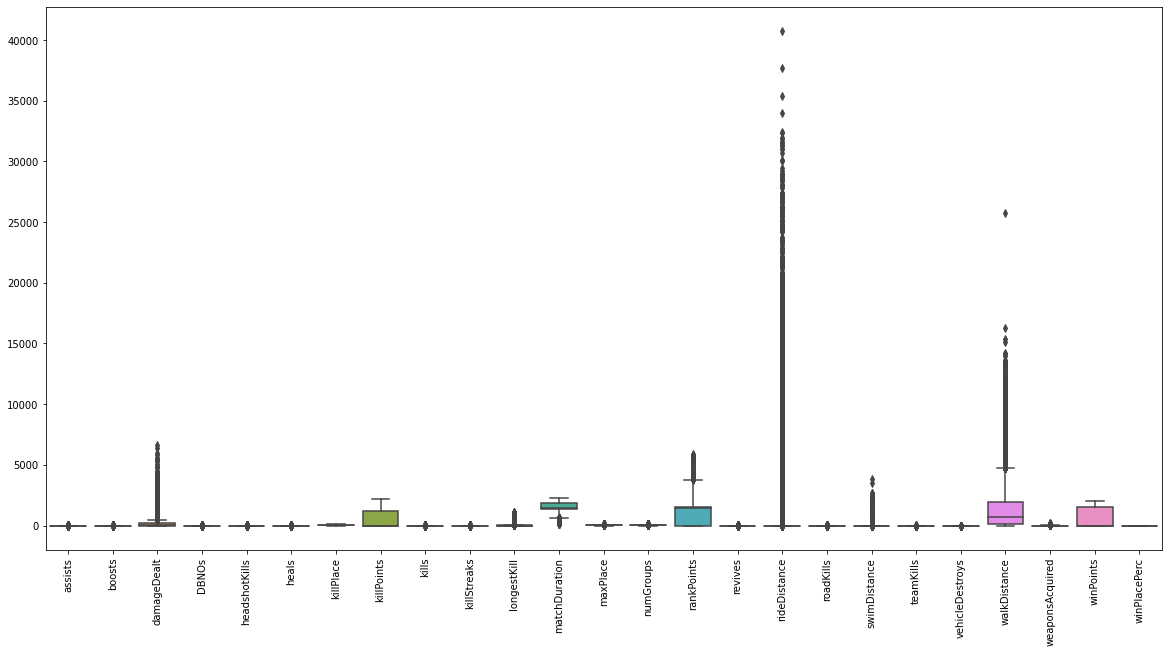

In [11]:
#박스플롯으로 전체적인 데이터 분석
fig,ax = plt.subplots(figsize=(20, 10))
sns.boxplot(data = train)
plt.xticks(rotation=90)
plt.show()

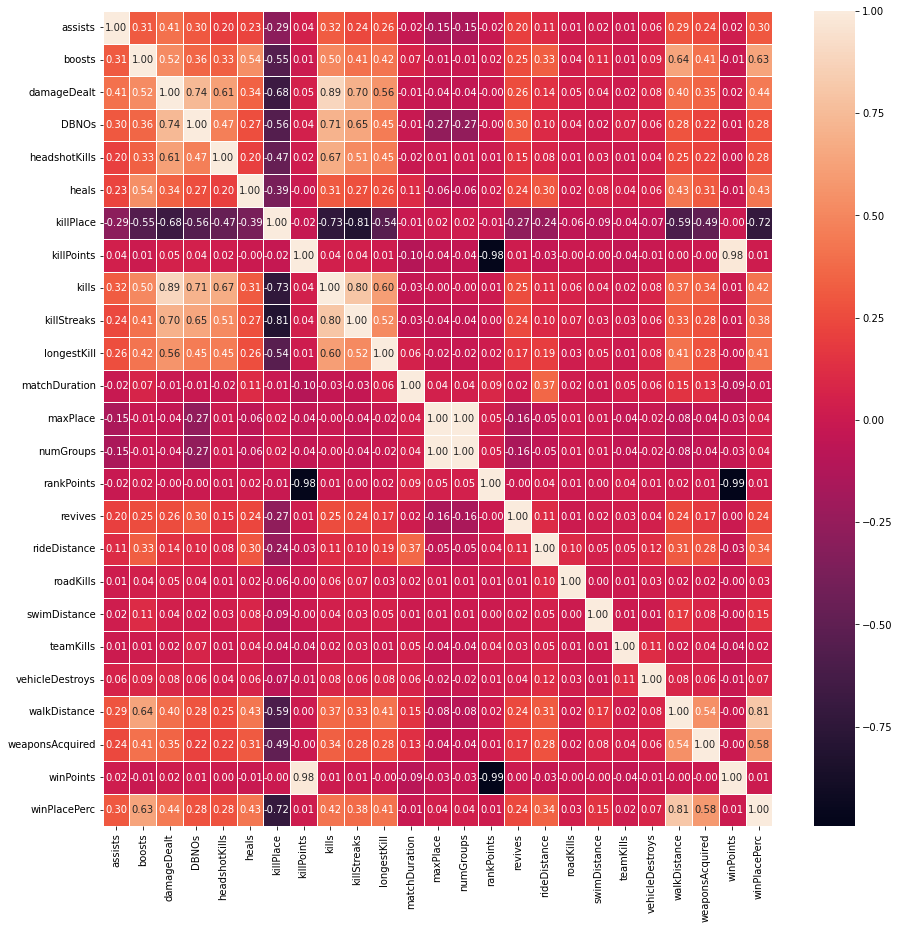

In [12]:
#feature별 상관관계 비교
fig,ax = plt.subplots(figsize=(15, 15))
sns.heatmap(train.corr(), annot=True, linewidths=.5, fmt= '.2f',ax=ax)
plt.show()

'killPoint' 와 'winPoint'는 양의 상관관계를 보이고, 다른 컬럼과도 비슷한 상관관계를 보인다.
'rankPoint'와는 음의 상관관계를 보인다.

'maxPlace' 와 'numGroups'는 동일한 컬럼이라고 봐도 무방하다. 둘 중 하나를 제거해주도록 한다.  

In [48]:
#EDA함수
def EDA_2graph(feature):
  print(train[feature].describe(),'\n\n','~'*90,'\n')
  print(train[feature].value_counts(),'\n\n','~'*90,'\n')
  
  plt.figure(figsize=(16,9))
  plt.subplot(1,2,1)
  sns.kdeplot(data = train, x = feature, hue = 'matchType')
  
  plt.subplot(1,2,2)
  sns.scatterplot(data = train, x = feature, y = 'winPlacePerc')
  plt.show()

def EDA_3graph(feature):
  print(train[feature].describe(),'\n\n','~'*90,'\n')
  print(train[feature].value_counts(),'\n\n','~'*90,'\n')
  
  plt.figure(figsize=(16,9))
  plt.subplot(2,2,3)
  sns.boxplot(data = train, x = feature, y = 'winPlacePerc')
  plt.xticks(rotation=90)
  
  plt.subplot(2,2,1)
  sns.countplot(data = train, x = feature)
  
  plt.subplot(1,2,2)
  sns.scatterplot(data = train, x = feature, y = 'winPlacePerc')
  plt.show()

## - Kill 관련 feature (8개)

### (1) damageDealt
피해를 입힌 전체 데미지 (단, 자해는 포함되지 않음)

count    4.446965e+06
mean     1.307172e+02
std      1.707806e+02
min      0.000000e+00
25%      0.000000e+00
50%      8.424000e+01
75%      1.860000e+02
max      6.616000e+03
Name: damageDealt, dtype: float64 

 ~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~ 

0.0000      1238101
100.0000     262781
200.0000      62398
300.0000      13767
75.0000       12825
             ...   
9.9160            1
0.1798            1
1.6690            1
0.5956            1
0.8705            1
Name: damageDealt, Length: 29916, dtype: int64 

 ~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~ 



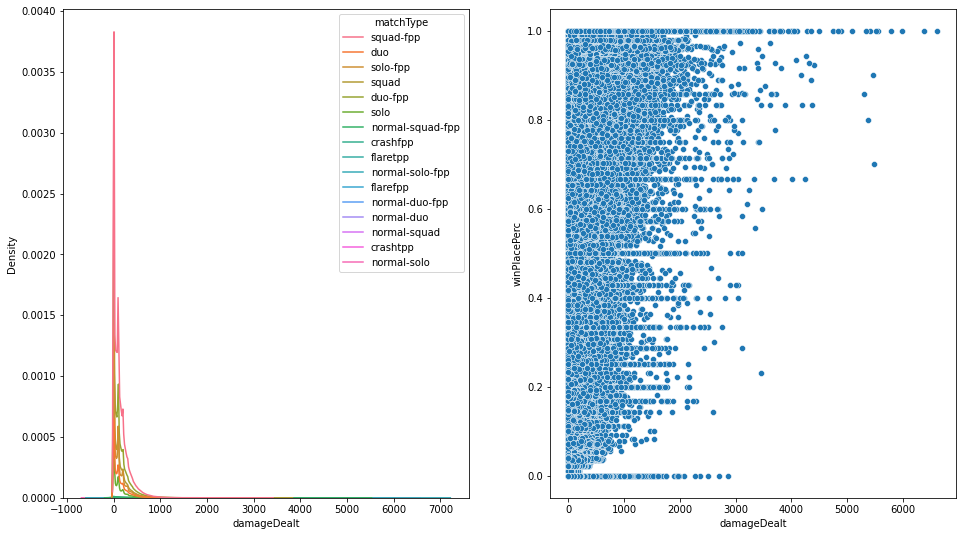

In [49]:
EDA_2graph('damageDealt')

대체로 최종 순위가 높을수록 딜량이 높은 경향을 보인다.

<span style='color:blue'> **최종 순위와 연관성이 있다** </span>

### (2) DBNOs(Down But Not Out)
기절시킨 적 플레이어의 수 (단, 적 팀원에 의해 부활되어 실제로는 킬로 처리되지 않음)

count    4.446965e+06
mean     6.578757e-01
std      1.145743e+00
min      0.000000e+00
25%      0.000000e+00
50%      0.000000e+00
75%      1.000000e+00
max      5.300000e+01
Name: DBNOs, dtype: float64 

 ~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~ 

0     2773734
1      983281
2      395119
3      162682
4       69307
5       31686
6       14977
7        7291
8        3694
9        1966
10       1110
11        643
12        466
13        275
14        177
15        137
16         87
17         80
18         64
19         34
20         30
21         26
22         18
25         16
23         14
26         11
24         10
33          7
27          6
32          3
31          3
28          3
39          2
38          1
30          1
29          1
35          1
40          1
53          1
Name: DBNOs, dtype: int64 

 ~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~ 



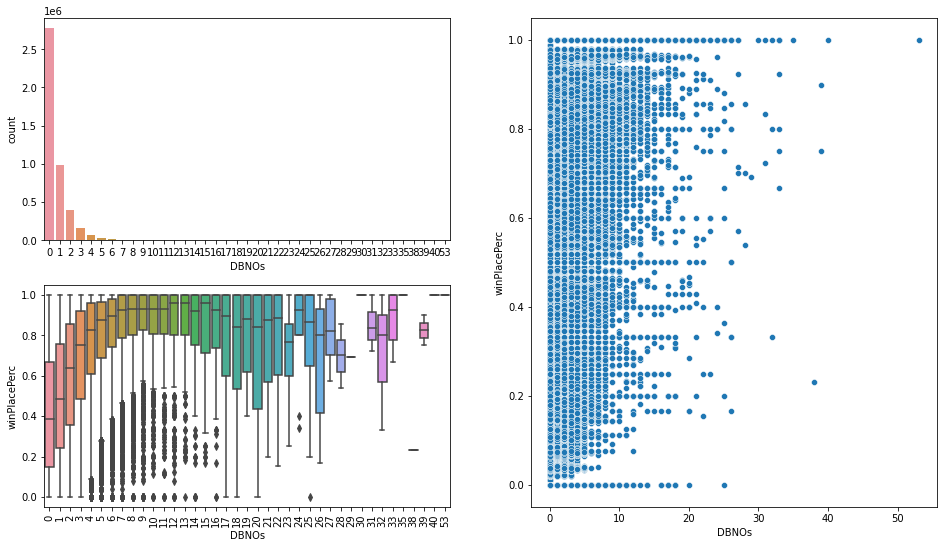

In [50]:
EDA_3graph('DBNOs')

대체로 최종 순위가 높을수록 많은 플레이어를 기절시킨 경향을 보인다.

<span style='color:blue'> **최종 순위와 연관성이 있다** </span>

### (3) headshotKills
헤드샷으로 처치한 적 플레이어의 수

count    4.446965e+06
mean     2.268196e-01
std      6.021553e-01
min      0.000000e+00
25%      0.000000e+00
50%      0.000000e+00
75%      0.000000e+00
max      6.400000e+01
Name: headshotKills, dtype: float64 

 ~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~ 

0     3696115
1      574741
2      126348
3       32975
4        9962
5        3616
6        1439
7         757
8         373
9         215
10        136
11         79
12         64
13         44
14         23
15         16
16         15
17         11
18          9
19          3
23          3
20          3
26          3
31          2
34          2
27          2
21          2
41          1
64          1
40          1
39          1
46          1
42          1
35          1
Name: headshotKills, dtype: int64 

 ~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~ 



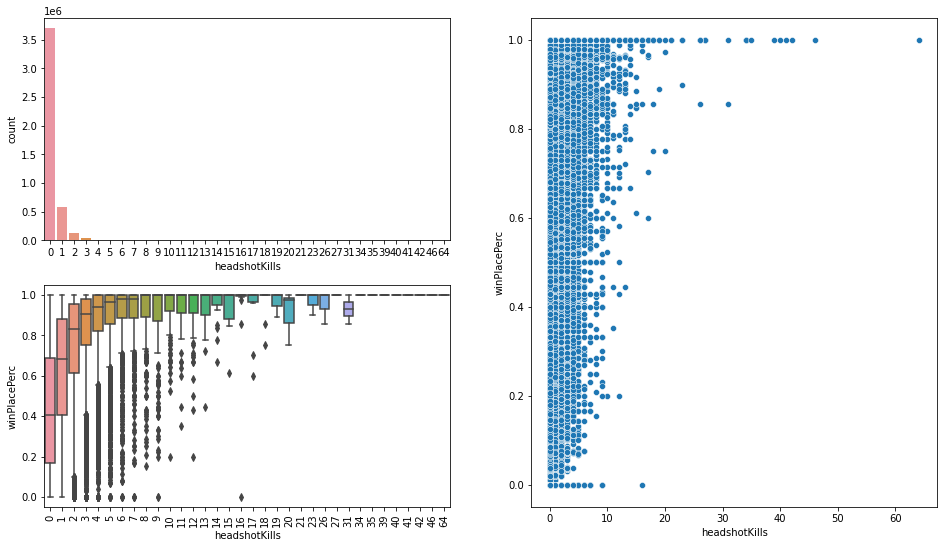

In [51]:
EDA_3graph('headshotKills')

대체로 최종 순위가 높을수록 많은 헤드샷 성공률을 보인다.

<span style='color:green'> **최종 순위와 매우 높은 연관성이 있다** </span>

### (4) killPlace
처치한 적 플레이어의 수에 따른 순위

count    4.446965e+06
mean     4.759936e+01
std      2.746293e+01
min      1.000000e+00
25%      2.400000e+01
50%      4.700000e+01
75%      7.100000e+01
max      1.010000e+02
Name: killPlace, dtype: float64 

 ~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~ 

2      47964
1      47964
5      47962
4      47962
3      47962
       ...  
97     16080
98     10005
99      4461
100     1415
101        1
Name: killPlace, Length: 101, dtype: int64 

 ~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~ 



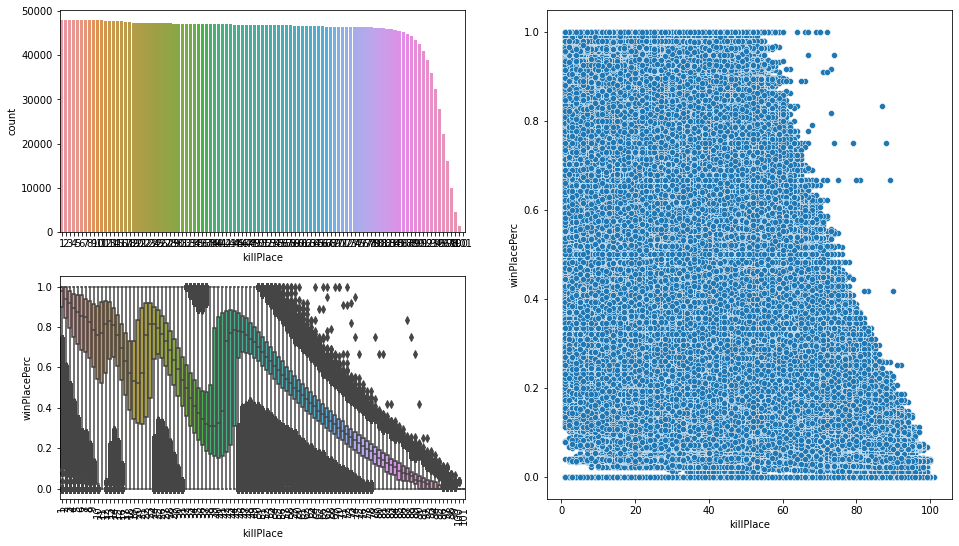

In [52]:
EDA_3graph('killPlace')

처치한 적 플레이어의 수에 따른 랭킹이 높을수록(killPlace가 작을수록) 최종순위가 높은 경향을 보인다.

<span style='color:green'> **최종 순위와 매우 높은 연관성이 있다** </span>

### (5) roadKills
탈것으로 처치한 적 플레이어의 수

count    4.446965e+06
mean     3.496092e-03
std      7.337297e-02
min      0.000000e+00
25%      0.000000e+00
50%      0.000000e+00
75%      0.000000e+00
max      1.800000e+01
Name: roadKills, dtype: float64 

 ~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~ 

0     4433969
1       11247
2        1298
3         297
4          72
5          36
6          20
7          11
8           7
9           2
11          2
10          2
14          1
18          1
Name: roadKills, dtype: int64 

 ~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~ 



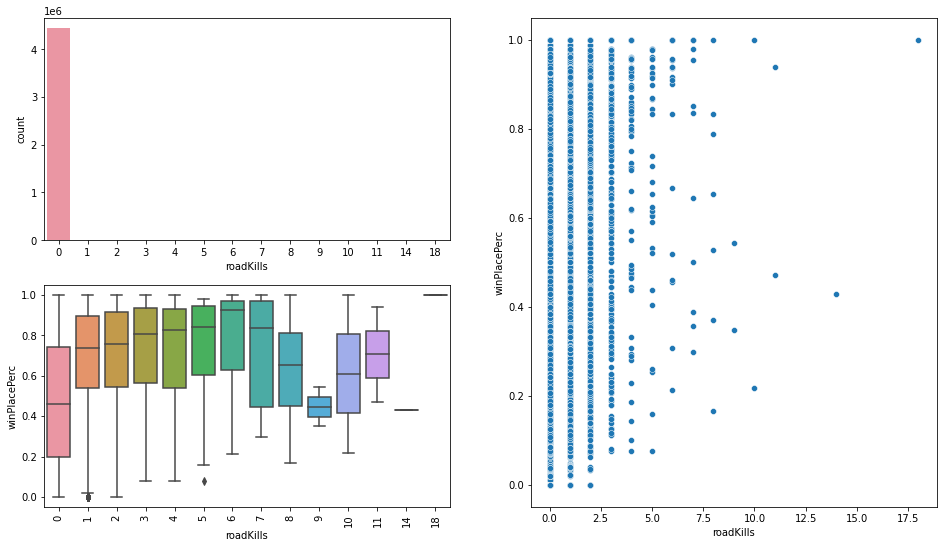

In [53]:
EDA_3graph('roadKills')

탈것을 탄 상태로 적을 처치한다고 해서 최종 순위가 높은 것은 아니다. 

하지만 어느정도 경향성은 보이므로 결정을 보류한다

<span style='color:purple'> **최종 순위와 연관이 있으나 feature 결정 시 낮은 우선순위 부여** </span>

### (6) kills
처치한 전체 플레이어의 수

count    4.446965e+06
mean     9.247835e-01
std      1.558445e+00
min      0.000000e+00
25%      0.000000e+00
50%      0.000000e+00
75%      1.000000e+00
max      7.200000e+01
Name: kills, dtype: float64 

 ~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~ 

0     2529721
1      928079
2      472466
3      232441
4      124543
5       66577
6       37960
7       21816
8       12779
9        7644
10       4599
11       2799
12       1755
13       1137
14        757
15        484
16        325
17        234
18        165
19        112
20        109
22         77
21         70
23         47
24         44
25         27
26         27
28         22
27         21
30         13
29         13
31         13
33         12
36          8
38          7
35          7
34          5
41          5
37          5
32          4
53          4
40          4
39          4
43          3
42          3
56          2
55          2
44          2
46          2
57          2


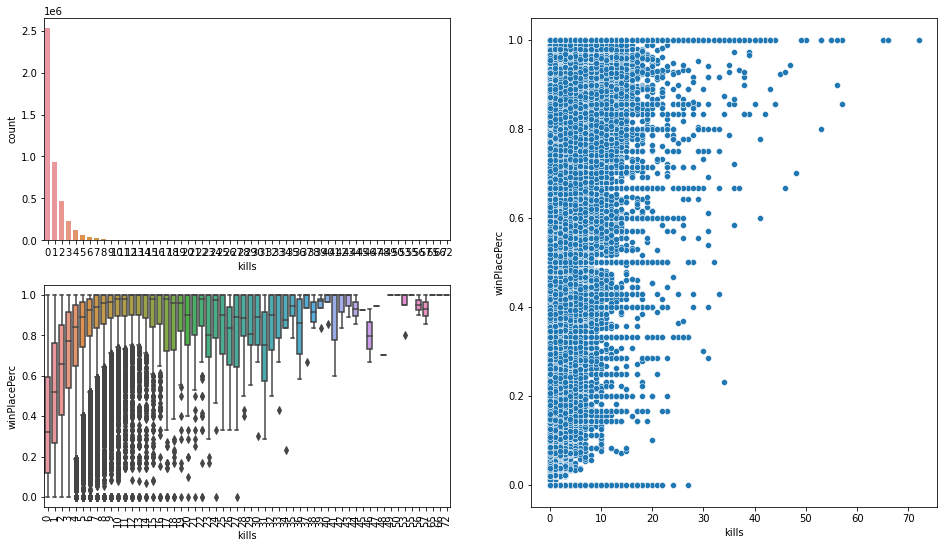

In [54]:
EDA_3graph('kills')

대체로 처치한 적이 많을수록 최종순위가 높다.

<span style='color:blue'> **최종 순위와 연관성이 있다** </span>

### (7) killStreaks
짧은 시간동안 처치한 최대 적 플레이어 수

count    4.446965e+06
mean     5.439553e-01
std      7.109721e-01
min      0.000000e+00
25%      0.000000e+00
50%      0.000000e+00
75%      1.000000e+00
max      2.000000e+01
Name: killStreaks, dtype: float64 

 ~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~ 

0     2529721
1     1475558
2      389346
3       45958
4        5711
5         409
6         126
7          54
8          32
9          18
10          9
11          8
13          5
12          5
14          2
16          1
18          1
20          1
Name: killStreaks, dtype: int64 

 ~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~ 



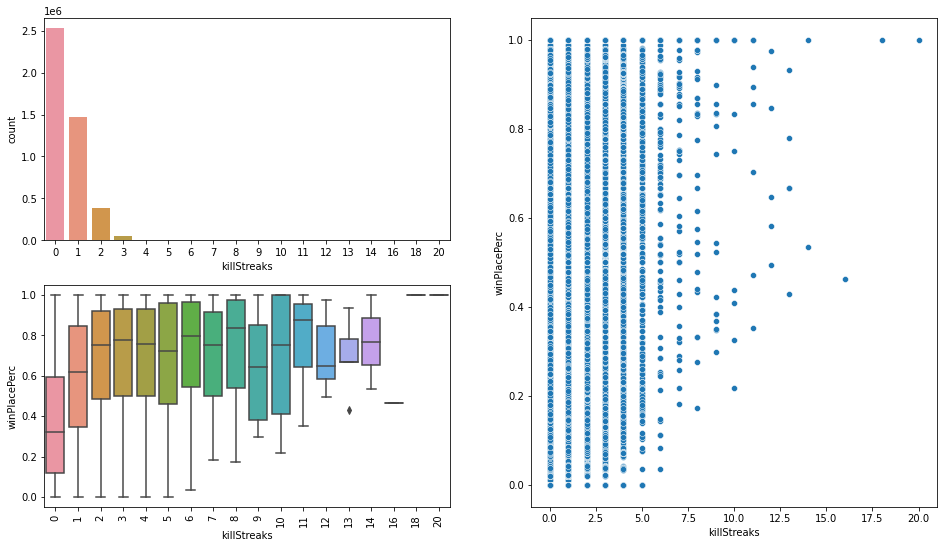

In [55]:
EDA_3graph('killStreaks')

미약한 차이지만 단시간 대비 최대 킬 수가 클수록 최종 순위가 높은 것을 알 수 있다.

<span style='color:blue'> **최종 순위와 연관성이 있다** </span>

### (8) longestKill
적 플레이어를 처치한 최장거리 기록

(단, 적 플레이어를 처치하고 탈것을 타고 도망간다면 longestKill 기록이 나올 수 있기 때문에 오해의 소지가 있다.)

count    4.446965e+06
mean     2.299760e+01
std      5.097262e+01
min      0.000000e+00
25%      0.000000e+00
50%      0.000000e+00
75%      2.132000e+01
max      1.094000e+03
Name: longestKill, dtype: float64 

 ~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~ 

0.0000      2538734
102.6000        457
101.1000        451
10.5000         449
11.4800         447
             ...   
545.2000          1
625.1000          1
581.5000          1
865.8000          1
0.7761            1
Name: longestKill, Length: 28284, dtype: int64 

 ~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~ 



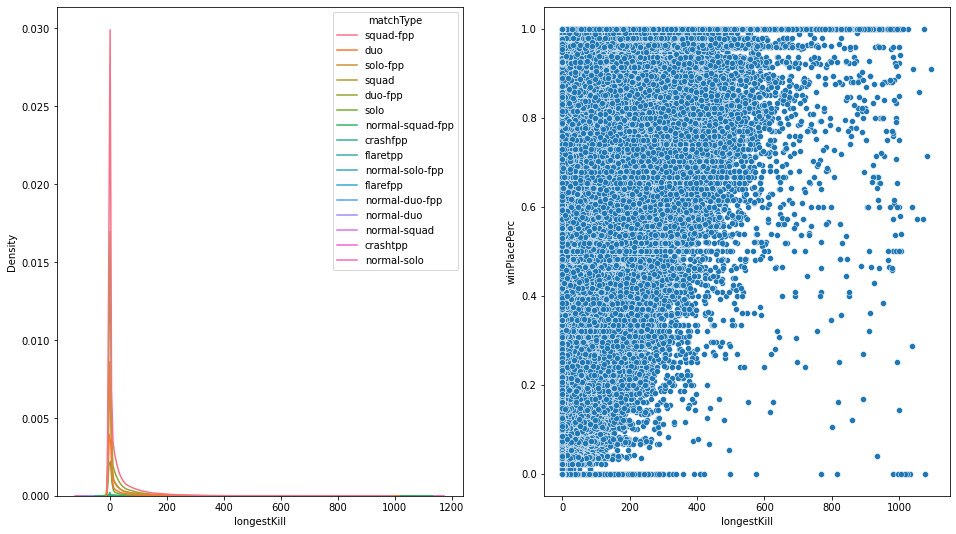

In [56]:
EDA_2graph('longestKill')

최종순위가 높을수록 적을 사살한 최대거리가 멀어지는 것을 알 수 있다.

<span style='color:green'> **최종 순위와 매우 높은 연관성이 있다** </span>

## - Heal 관련 feature

### (1) boosts

부스트 아이템 사용 횟수

count    4.446965e+06
mean     1.106908e+00
std      1.715794e+00
min      0.000000e+00
25%      0.000000e+00
50%      0.000000e+00
75%      2.000000e+00
max      3.300000e+01
Name: boosts, dtype: float64 

 ~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~ 

0     2521323
1      680252
2      491316
3      295883
4      195729
5      120271
6       70111
7       37626
8       18893
9        8638
10       3992
11       1644
12        726
13        295
14        126
15         62
16         30
17         16
18         13
19          6
21          4
20          3
24          2
33          1
28          1
23          1
22          1
Name: boosts, dtype: int64 

 ~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~ 



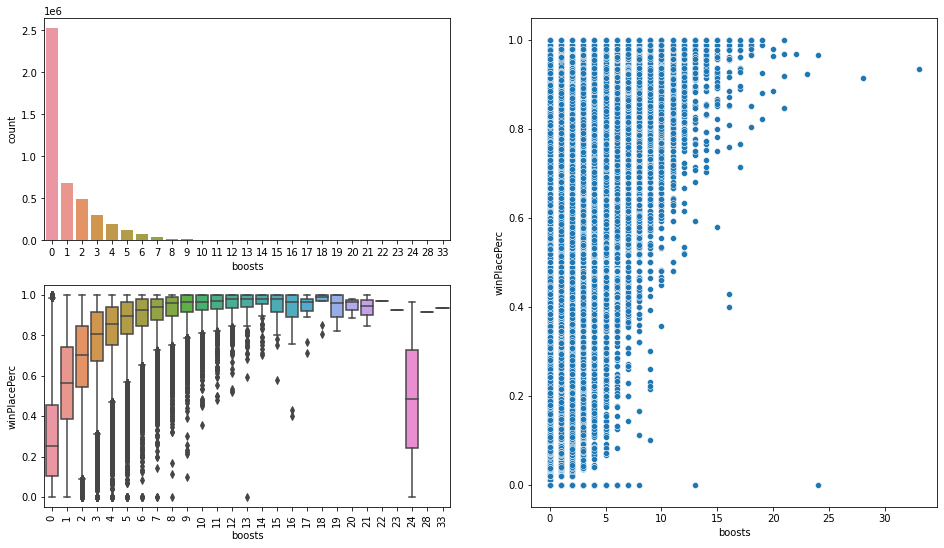

In [57]:
EDA_3graph('boosts')

최종 순위가 높을수록 오래 살아남기 때문에 부스트 아이템을 많이 사용함을 알 수 있다. 

<span style='color:green'> **최종 순위와 매우 높은 연관성이 있다** </span>

### (2) heals

힐링 아이템 사용 횟수

count    4.446965e+06
mean     1.370148e+00
std      2.679982e+00
min      0.000000e+00
25%      0.000000e+00
50%      0.000000e+00
75%      2.000000e+00
max      8.000000e+01
Name: heals, dtype: float64 

 ~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~ 

0     2648197
1      673077
2      319387
3      202370
4      142637
       ...   
57          1
56          1
73          1
80          1
62          1
Name: heals, Length: 63, dtype: int64 

 ~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~ 



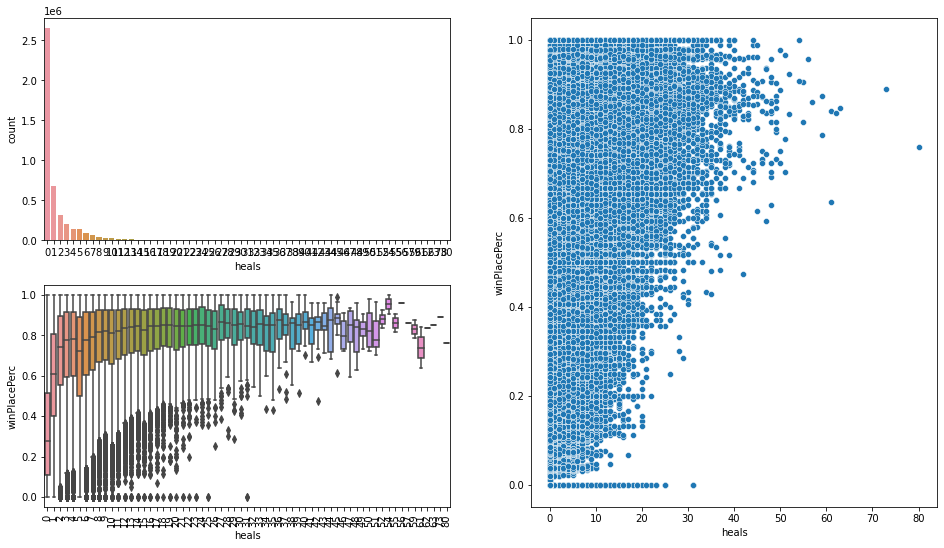

In [58]:
EDA_3graph('heals')

최종 순위가 높음에 따라 회복 아이템 사용빈도가 높아지는 모습이 뚜렷하게 보인다.

<span style='color:green'> **최종 순위와 매우 높은 연관성이 있다** </span>

## - Assist 관련 feature

### (1) assists
아군이 적 플레이어를 처치했을 때, 같이 데미지를 입힌 적 플레이어의 수

count    4.446965e+06
mean     2.338150e-01
std      5.885731e-01
min      0.000000e+00
25%      0.000000e+00
50%      0.000000e+00
75%      0.000000e+00
max      2.200000e+01
Name: assists, dtype: float64 

 ~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~ 

0     3667659
1      591883
2      137144
3       35640
4        9990
5        2892
6         976
7         387
8         185
9          84
10         48
11         27
12         20
13         16
15          7
14          2
17          2
21          1
20          1
22          1
Name: assists, dtype: int64 

 ~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~ 



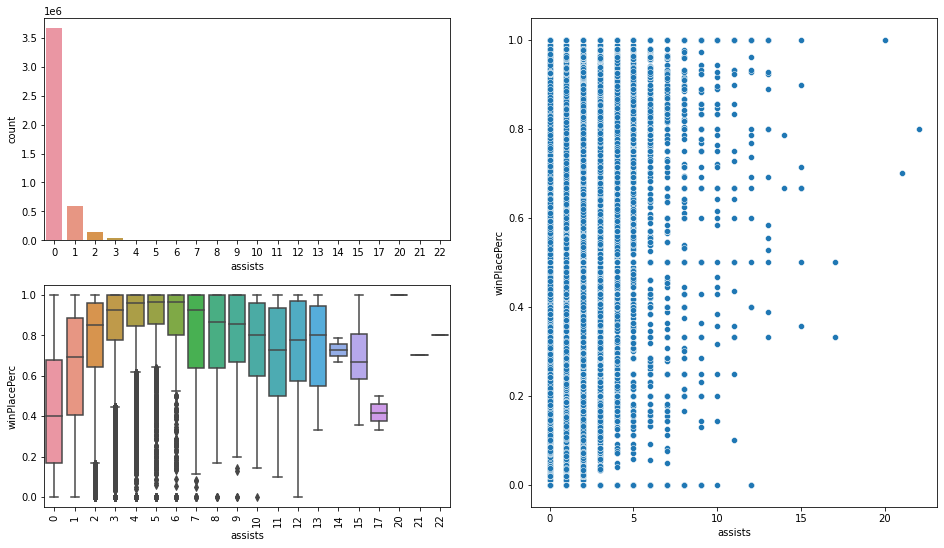

In [59]:
EDA_3graph('assists')

최종 순위가 증가함에 따라 어시횟수가 증가하는 경향을 보이다가 9회 이상부터는 다소 감소하는 추세를 보인다.어느정도 일정한 경향성을 보이기 때문에 연관있다.

<span style='color:blue'> **최종 순위와 연관성이 있다** </span>

### (2) revives 

팀 동료를 되살린 수

count    4.446965e+06
mean     1.646590e-01
std      4.721671e-01
min      0.000000e+00
25%      0.000000e+00
50%      0.000000e+00
75%      0.000000e+00
max      3.900000e+01
Name: revives, dtype: float64 

 ~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~ 

0     3859866
1      470110
2       95545
3       17333
4        3102
5         606
6         142
7          72
8          43
9          26
10         25
11         23
15         13
12         12
14         10
13          7
18          7
16          6
17          6
19          3
23          3
20          2
28          1
39          1
32          1
Name: revives, dtype: int64 

 ~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~ 



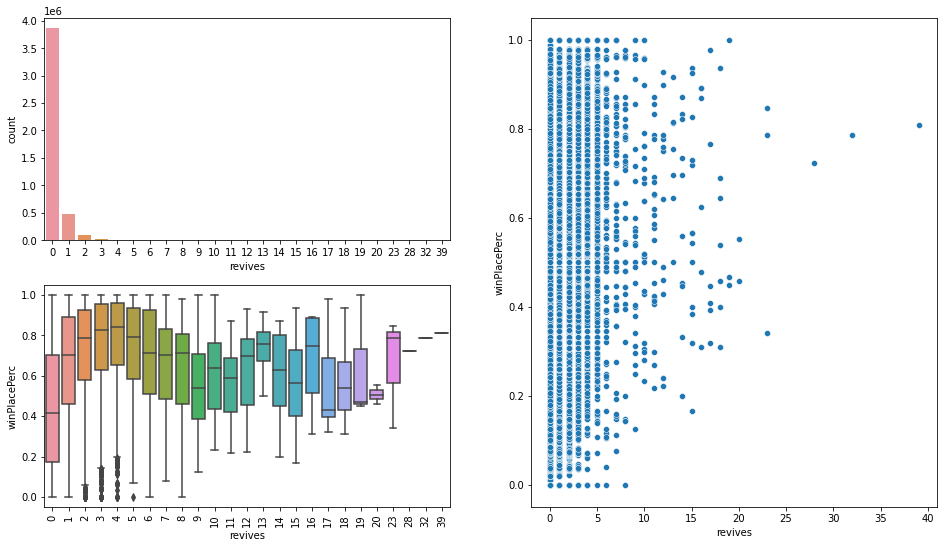

In [60]:
EDA_3graph('revives')

최종 순위가 증가함에 따라 부활 횟수가 증가하는 경향을 보이다가 5회 이상부터는 다소 감소하는 추세를 보이고,
다시 12회부터는 상승과 하락을 반복하는 모습을 보인다.

<span style='color:purple'> **최종 순위와 연관성이 있긴하지만 feature 결정 시 낮은 우선순위 부여** </span>

## - Farming 관련 feature (1개)

### (1) weaponsAcquired 

획득한 무기의 수

count    4.446965e+06
mean     3.660488e+00
std      2.456543e+00
min      0.000000e+00
25%      2.000000e+00
50%      3.000000e+00
75%      5.000000e+00
max      2.360000e+02
Name: weaponsAcquired, dtype: float64 

 ~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~ 

2      768836
3      768347
4      689622
1      580951
5      540721
        ...  
83          1
102         1
77          1
128         1
92          1
Name: weaponsAcquired, Length: 97, dtype: int64 

 ~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~ 



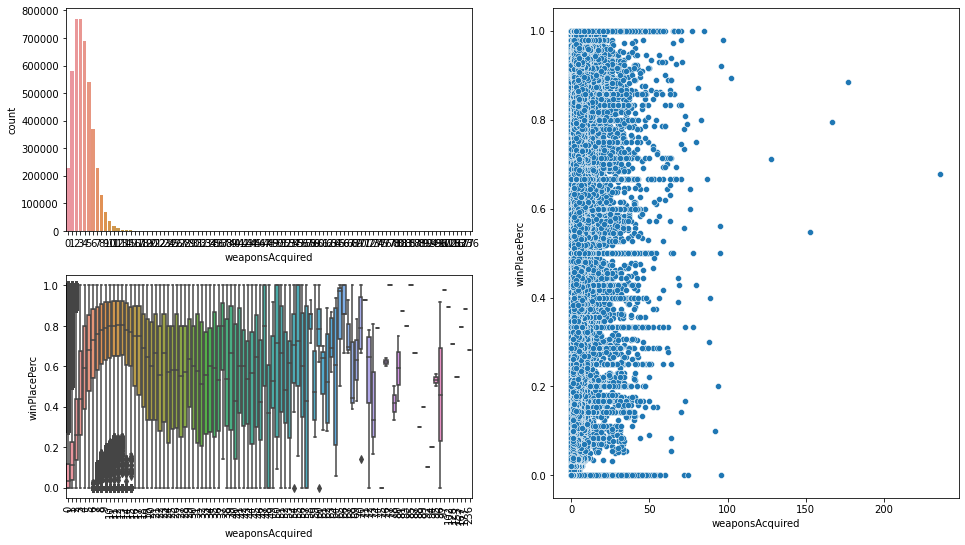

In [61]:
EDA_3graph('weaponsAcquired')

어느정도 무기 파밍을 많이 할수록 최종 순위가 높아지는 경향을 보이긴하지만, 20개 정도의 무기를 획득한 순간부터는 큰 영향을 끼치진 않는다.

<span style='color:purple'> **최종 순위와 연관성이 있긴하지만 feature 결정 시 낮은 우선순위 부여** </span>

## - Activity 관련 feature (3개)

### (1) rideDistance

탈것으로 이동한 전체 거리 (m,미터)

count    4.446965e+06
mean     6.061158e+02
std      1.498344e+03
min      0.000000e+00
25%      0.000000e+00
50%      0.000000e+00
75%      1.910000e-01
max      4.071000e+04
Name: rideDistance, dtype: float64 

 ~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~ 

0.0000       3309428
1010.0000        334
1158.0000        332
1045.0000        331
1318.0000        329
              ...   
21.7000            1
77.1400            1
9.3210             1
0.1759             1
69.5100            1
Name: rideDistance, Length: 33562, dtype: int64 

 ~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~ 



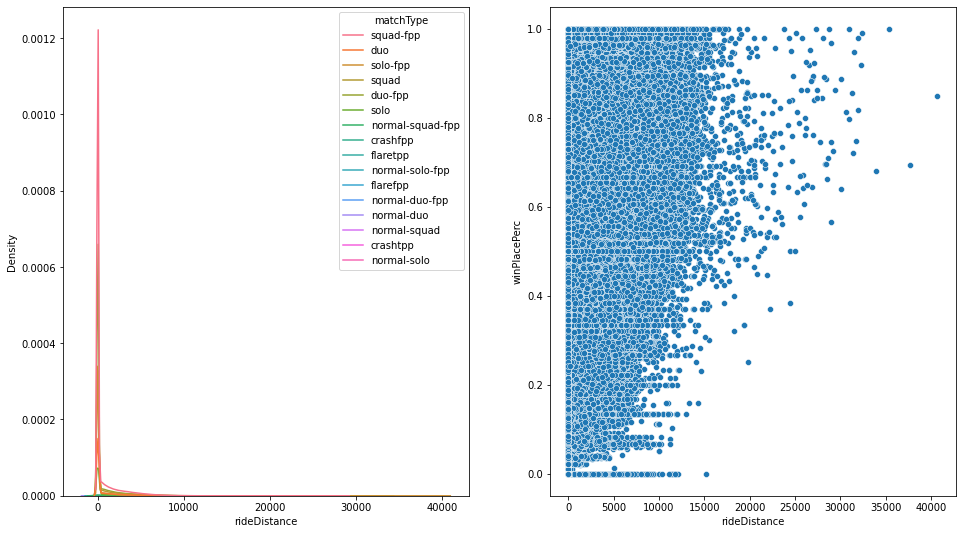

In [62]:
EDA_2graph('rideDistance')

탈것을 타고 많이 이동했을때 대체로 최종순위가 높음을 확인할 수 있다.

<span style='color:green'> **최종 순위와 매우 높은 연관성이 있다** </span>

### (2) swimDistance

수영으로 이동한 전체 거리 (m,미터)

count    4.446965e+06
mean     4.509323e+00
std      3.050220e+01
min      0.000000e+00
25%      0.000000e+00
50%      0.000000e+00
75%      0.000000e+00
max      3.823000e+03
Name: swimDistance, dtype: float64 

 ~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~ 

0.0000      4157693
102.4000        122
101.4000        104
102.8000        104
114.1000         99
             ...   
0.4356            1
0.1446            1
0.7684            1
0.7948            1
802.6000          1
Name: swimDistance, Length: 28345, dtype: int64 

 ~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~ 



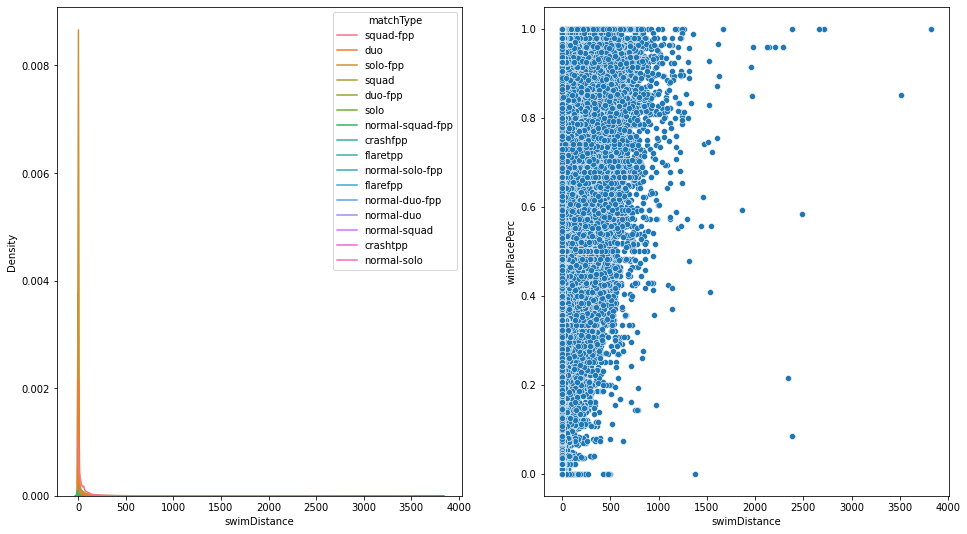

In [63]:
EDA_2graph('swimDistance')

몇몇 아웃라이어를 제외하곤 대체로 수영 거리가 멀수록 높은 최종 순위를 보인다.

<span style='color:green'> **최종 순위와 매우 높은 연관성이 있다** </span>

### (3) walkDistance

걸어서 이동한 전체 거리 (m,미터)

count    4.446965e+06
mean     1.154218e+03
std      1.183497e+03
min      0.000000e+00
25%      1.551000e+02
50%      6.856000e+02
75%      1.976000e+03
max      2.578000e+04
Name: walkDistance, dtype: float64 

 ~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~ 

0.0000       99602
1007.0000      955
1098.0000      945
1047.0000      939
1036.0000      934
             ...  
0.8005           1
0.3570           1
7935.0000        1
0.8721           1
0.9661           1
Name: walkDistance, Length: 38599, dtype: int64 

 ~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~ 



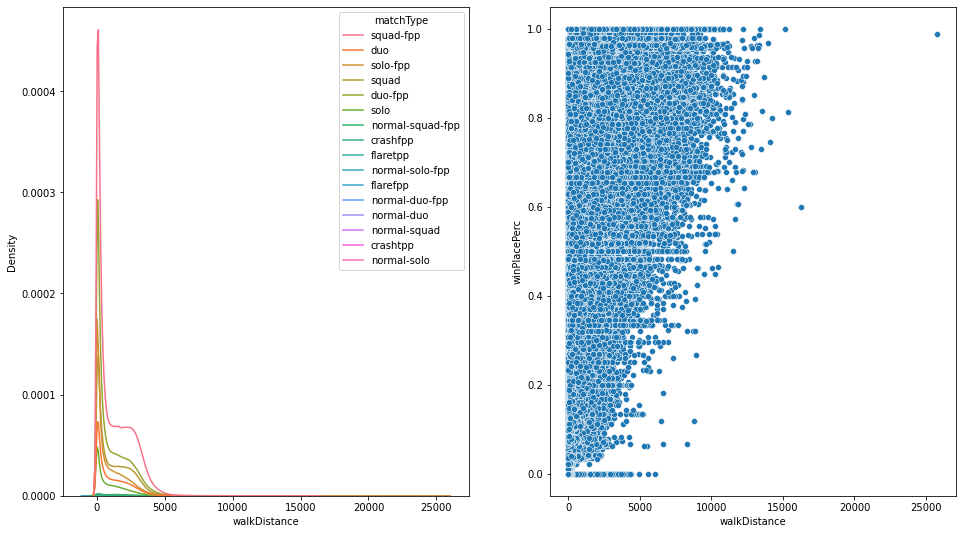

In [64]:
EDA_2graph('walkDistance')

걸어서 이동한 거리가 멀수록 최종 순위가 높아지는 경향이 뚜렷하게 나타난다.

<span style='color:green'> **최종 순위와 매우 높은 연관성이 있다** </span>

## - play에 영향을 주는 특이한 변수 관련 feature (2개)

### (1) teamKills
같은 팀동료를 사살한 횟수

count    4.446965e+06
mean     2.386841e-02
std      1.673935e-01
min      0.000000e+00
25%      0.000000e+00
50%      0.000000e+00
75%      0.000000e+00
max      1.200000e+01
Name: teamKills, dtype: float64 

 ~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~ 

0     4350035
1       88771
2        7236
3         829
4          81
5           7
10          2
7           1
12          1
6           1
8           1
Name: teamKills, dtype: int64 

 ~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~ 



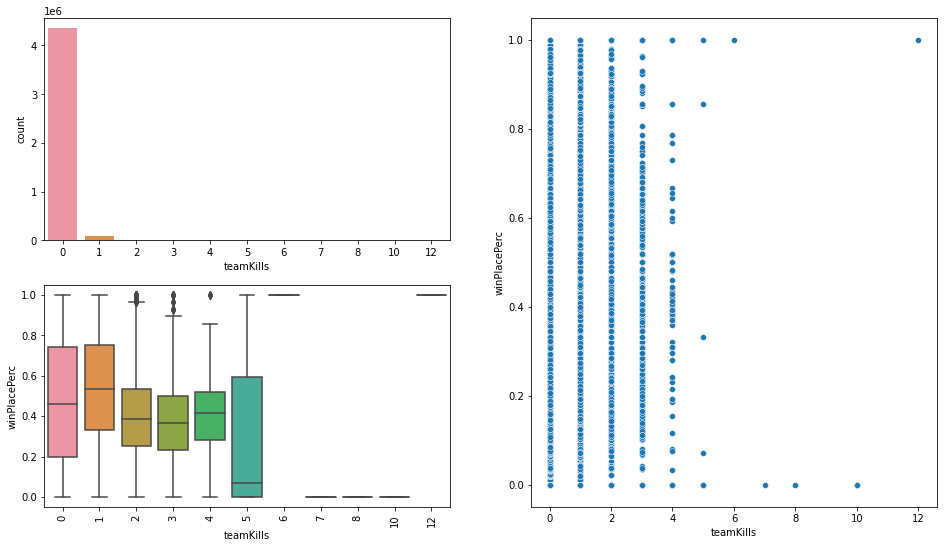

In [65]:
EDA_3graph('teamKills')

팀킬이 많을수록 최종 순위가 높은 데이터양이 적어지긴하지만 최종 순위에 큰 영향을 줄 정도로 크진않다.

<span style='color:red'> **최종 순위와 큰 관련이 없다** </span>

### (2) vehicleDestroys

탈것을 파괴시킨 횟수

count    4.446965e+06
mean     7.918209e-03
std      9.261158e-02
min      0.000000e+00
25%      0.000000e+00
50%      0.000000e+00
75%      0.000000e+00
max      5.000000e+00
Name: vehicleDestroys, dtype: float64 

 ~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~ 

0    4413211
1      32422
2       1223
3         95
4         11
5          3
Name: vehicleDestroys, dtype: int64 

 ~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~ 



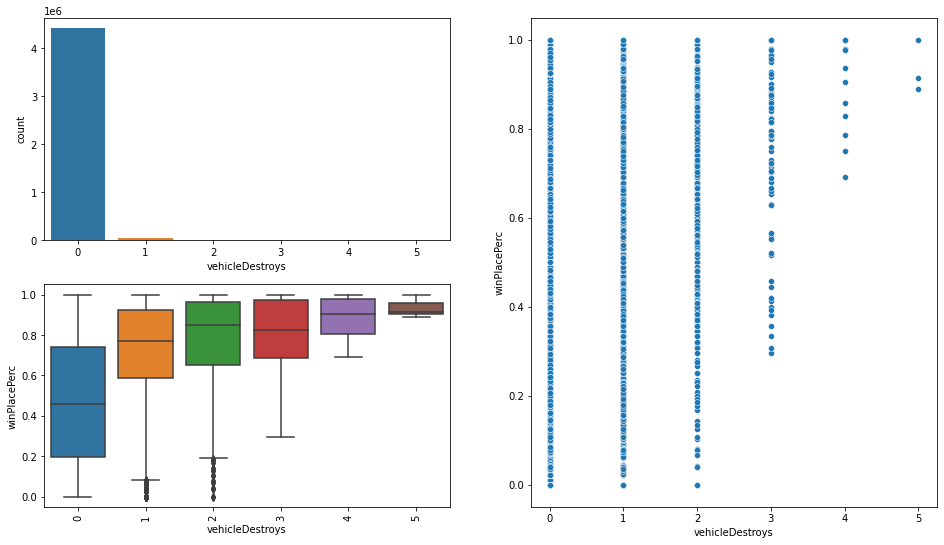

In [66]:
EDA_3graph('vehicleDestroys')

예상외로 최종 순위가 높을수록 많은 수의 탈것들을 파괴하는 모습을 보였다. 견제(다른 유저가 사용 못하도록 파괴) 또는 공격등의 이유로 탈것을 많이 파괴한 결과 높은 연관성이 나타난 것으로 보인다.

<span style='color:green'> **최종 순위와 매우 높은 연관성이 있다** </span>

## - 이외의 game 관련 feature (7개)

### (1) matchDuration

경기 시간 (s,초)

count    4.446965e+06
mean     1.579507e+03
std      2.587388e+02
min      1.330000e+02
25%      1.367000e+03
50%      1.438000e+03
75%      1.851000e+03
max      2.237000e+03
Name: matchDuration, dtype: float64 

 ~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~ 

1384    27764
1374    27259
1376    26755
1380    26728
1381    26261
        ...  
635         7
1053        7
877         7
728         5
133         2
Name: matchDuration, Length: 1266, dtype: int64 

 ~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~ 



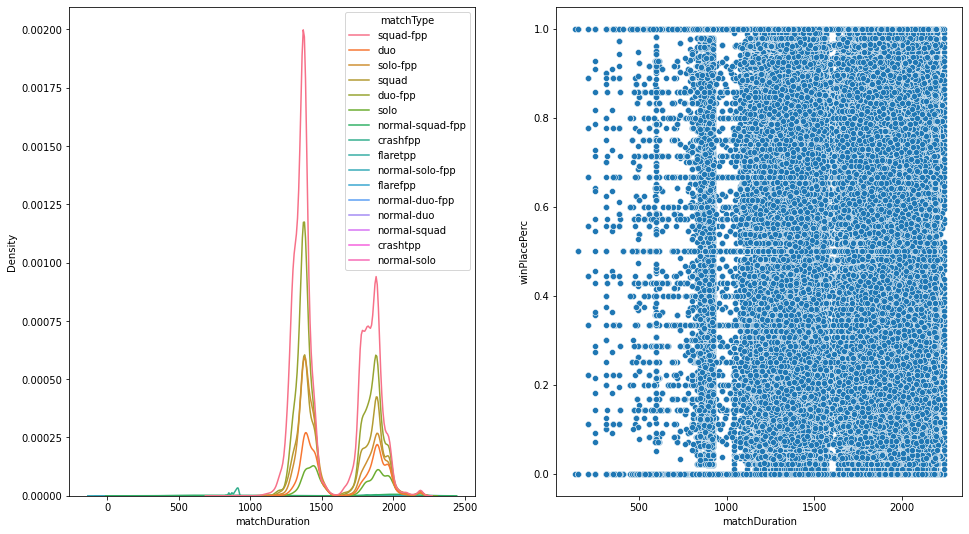

In [67]:
EDA_2graph('matchDuration')

경기 시간이 크게 두 그룹으로 분류된 형태인 점은 신기하지만 최종 순위와는 큰 연관은 없어보인다.

<span style='color:red'> **최종 순위와 큰 관련이 없다** </span>

### (2) matchType

매치 타입 >> “solo”, “duo”, “squad”, “solo-fpp”, “duo-fpp”, “squad-fpp” 

나머지는 이벤트 또는 커스텀 매치

count       4446965
unique           16
top       squad-fpp
freq        1756186
Name: matchType, dtype: object 

 ~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~ 

squad-fpp           1756186
duo-fpp              996691
squad                626526
solo-fpp             536761
duo                  313591
solo                 181943
normal-squad-fpp      17174
crashfpp               6287
normal-duo-fpp         5489
flaretpp               2505
normal-solo-fpp        1682
flarefpp                718
normal-squad            516
crashtpp                371
normal-solo             326
normal-duo              199
Name: matchType, dtype: int64 

 ~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~ 



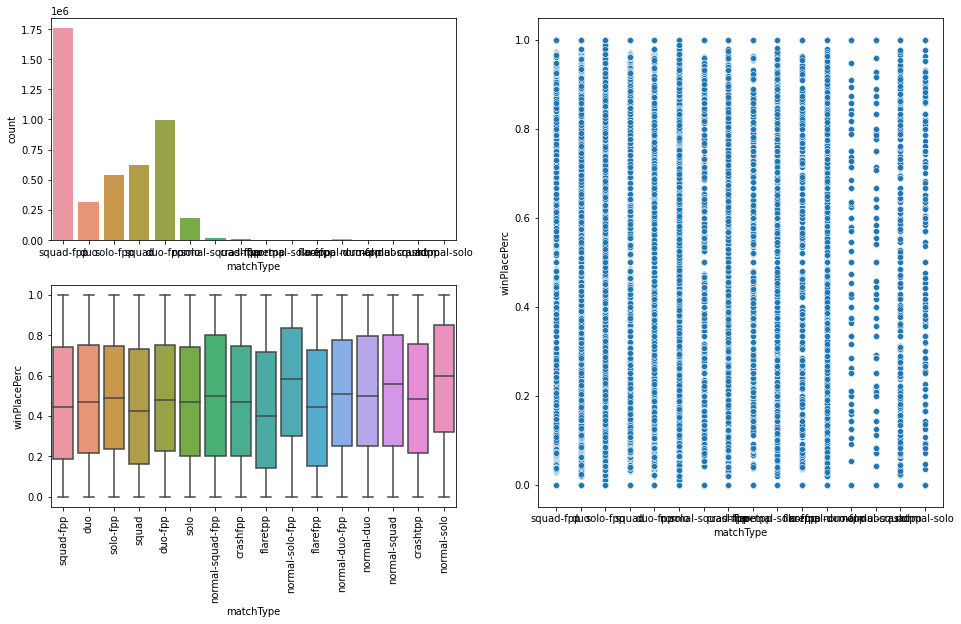

In [68]:
EDA_3graph('matchType')

경기 참여 인원 별, 플레이어 시점 별 분류 기준으로 사용할 것이기 때문에 굳이 영향력을 찾지 않는다.

<span style='color:orange'> **feature 분류 기준으로 사용 예정** </span>

### (3) maxPlace 

경기 중 최저 순위 (보유하고 있는 데이터 한정)

(단, 가끔씩 데이터들이 순위를 스킵하기 때문에 numGroup과 일치하지 않을 수 있다.)

count    4.446965e+06
mean     4.450468e+01
std      2.382810e+01
min      2.000000e+00
25%      2.800000e+01
50%      3.000000e+01
75%      4.900000e+01
max      1.000000e+02
Name: maxPlace, dtype: float64 

 ~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~ 

28    626495
29    507498
27    495114
49    367998
48    329050
       ...  
59       118
58       116
56       112
61        61
53        53
Name: maxPlace, Length: 99, dtype: int64 

 ~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~ 



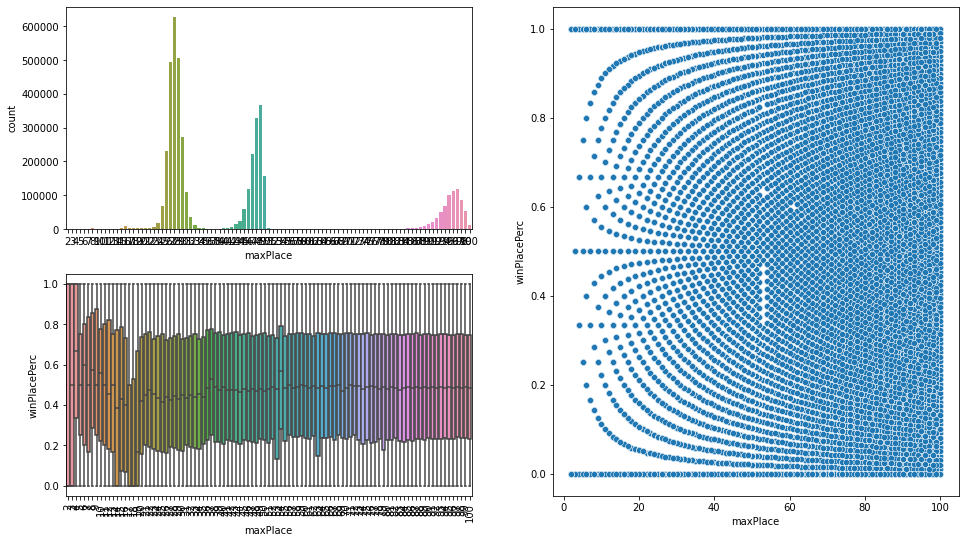

In [69]:
EDA_3graph('maxPlace')

최종 순위와 상관없이 고른 분포를 보이고 있어 큰 관련성은 없어보인다.

<span style='color:red'> **최종 순위와 큰 관련이 없다** </span>

### (4) numGroups

게임에 참여한 데이터가 있는 그룹의 수 

count    4.446965e+06
mean     4.300760e+01
std      2.328949e+01
min      1.000000e+00
25%      2.700000e+01
50%      3.000000e+01
75%      4.700000e+01
max      1.000000e+02
Name: numGroups, dtype: float64 

 ~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~ 

27    537607
28    488669
26    416744
29    314665
47    269503
       ...  
54       112
66        85
62        64
57        58
55        56
Name: numGroups, Length: 100, dtype: int64 

 ~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~ 



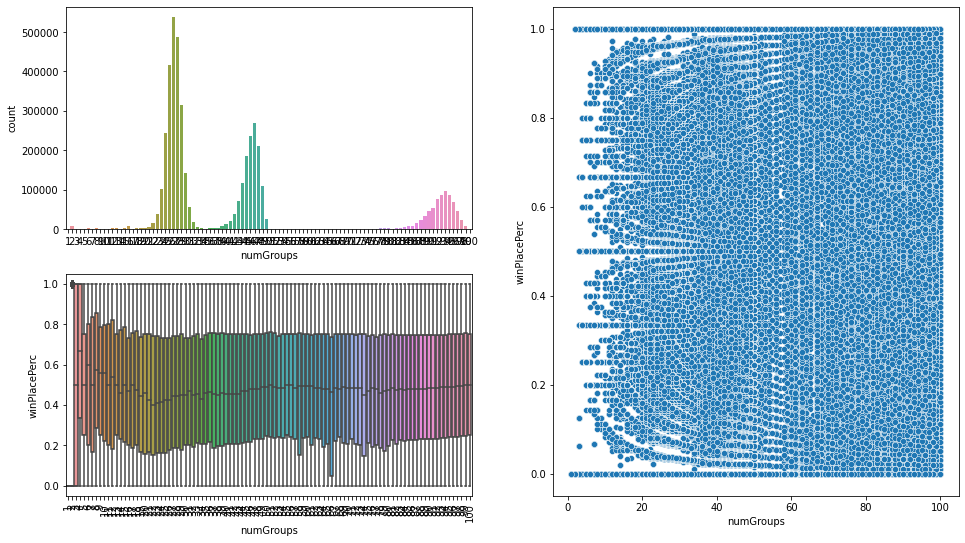

In [70]:
EDA_3graph('numGroups')

최종 순위와 상관없이 고른 분포를 보이고 있어 큰 관련성은 없어보인다.

<span style='color:red'> **최종 순위와 큰 관련이 없다** </span>

### (5) rankPoints

플레이어의 Elo 랭킹 같은 개념.

(단, 이 순위는 일관성이 없으며 차기 API 버전에서 더 이상 사용되지 않으므로 사용에 주의해야한다. -1값은 'None'을 의미한다.)

count    4.446965e+06
mean     8.920103e+02
std      7.366478e+02
min     -1.000000e+00
25%     -1.000000e+00
50%      1.443000e+03
75%      1.500000e+03
max      5.910000e+03
Name: rankPoints, dtype: float64 

 ~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~ 

-1       1701810
 1500     299741
 0         89509
 1480      48857
 1494      42612
          ...   
 2578          1
 2898          1
 2697          1
 2439          1
 2962          1
Name: rankPoints, Length: 2262, dtype: int64 

 ~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~ 



/Users/krc/downloads/yes/lib/python3.9/site-packages/seaborn/distributions.py:316: UserWarning: Dataset has 0 variance; skipping density estimate. Pass `warn_singular=False` to disable this warning.
  warnings.warn(msg, UserWarning)
/Users/krc/downloads/yes/lib/python3.9/site-packages/seaborn/distributions.py:316: UserWarning: Dataset has 0 variance; skipping density estimate. Pass `warn_singular=False` to disable this warning.
  warnings.warn(msg, UserWarning)
/Users/krc/downloads/yes/lib/python3.9/site-packages/seaborn/distributions.py:316: UserWarning: Dataset has 0 variance; skipping density estimate. Pass `warn_singular=False` to disable this warning.
  warnings.warn(msg, UserWarning)


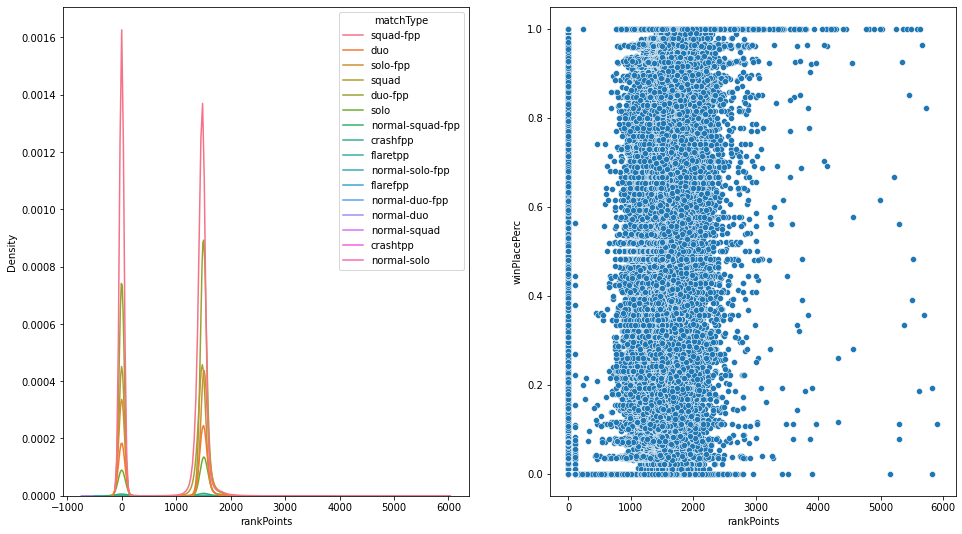

In [71]:
EDA_2graph('rankPoints')

최종 순위와 상관없이 고른 분포를 보이고 있어 큰 관련성은 없어보인다.

<span style='color:red'> **최종 순위와 큰 관련이 없다** </span>

### (6) winPoints

승리 횟수로만 판단한 플레이어의 외적 순위. (= 승리 횟수만 고려한 Elo 순위)

만약 rankPoints에 -1 이외의 값이 있다면, winPoints의 모든 '0'값을 'None'으로 처리해야한다. 

count    4.446965e+06
mean     6.064603e+02
std      7.397005e+02
min      0.000000e+00
25%      0.000000e+00
50%      0.000000e+00
75%      1.495000e+03
max      2.013000e+03
Name: winPoints, dtype: float64 

 ~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~ 

0       2655646
1500     153675
1502      18859
1501      18829
1503      18752
         ...   
888           1
913           1
1044          1
1053          1
916           1
Name: winPoints, Length: 1447, dtype: int64 

 ~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~ 



/Users/krc/downloads/yes/lib/python3.9/site-packages/seaborn/distributions.py:316: UserWarning: Dataset has 0 variance; skipping density estimate. Pass `warn_singular=False` to disable this warning.
  warnings.warn(msg, UserWarning)
/Users/krc/downloads/yes/lib/python3.9/site-packages/seaborn/distributions.py:316: UserWarning: Dataset has 0 variance; skipping density estimate. Pass `warn_singular=False` to disable this warning.
  warnings.warn(msg, UserWarning)
/Users/krc/downloads/yes/lib/python3.9/site-packages/seaborn/distributions.py:316: UserWarning: Dataset has 0 variance; skipping density estimate. Pass `warn_singular=False` to disable this warning.
  warnings.warn(msg, UserWarning)


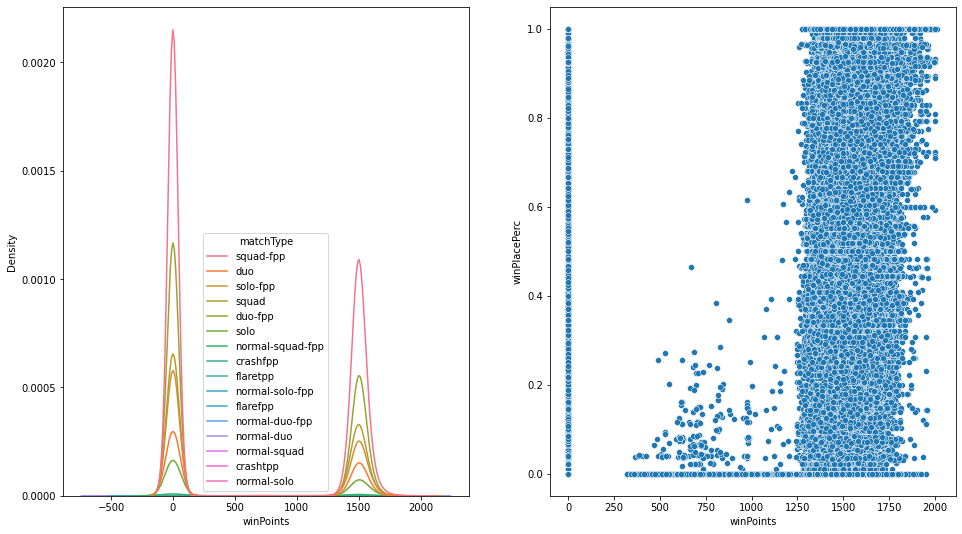

In [72]:
EDA_2graph('winPoints')

최종 순위와 상관없이 고른 분포를 보이고 있어 큰 관련성은 없어보인다.

<span style='color:red'> **최종 순위와 큰 관련이 없다** </span>

### (7) killPoints
킬 수 기반의 외적인 플레이어 순위 (=오직 킬 수로만 산정한 Elo 순위의 개념) 

만약 rankPoints에 -1 이외의 값이 있다면, killPoints의 0값은 값이 'None'으로 처리해야한다.

count    4.446965e+06
mean     5.050062e+02
std      6.275049e+02
min      0.000000e+00
25%      0.000000e+00
50%      0.000000e+00
75%      1.172000e+03
max      2.170000e+03
Name: killPoints, dtype: float64 

 ~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~ 

0       2655646
1000     137679
1256       3433
1233       3334
1268       3320
         ...   
2002          1
379           1
430           1
549           1
392           1
Name: killPoints, Length: 1707, dtype: int64 

 ~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~ 



/Users/krc/downloads/yes/lib/python3.9/site-packages/seaborn/distributions.py:316: UserWarning: Dataset has 0 variance; skipping density estimate. Pass `warn_singular=False` to disable this warning.
  warnings.warn(msg, UserWarning)
/Users/krc/downloads/yes/lib/python3.9/site-packages/seaborn/distributions.py:316: UserWarning: Dataset has 0 variance; skipping density estimate. Pass `warn_singular=False` to disable this warning.
  warnings.warn(msg, UserWarning)
/Users/krc/downloads/yes/lib/python3.9/site-packages/seaborn/distributions.py:316: UserWarning: Dataset has 0 variance; skipping density estimate. Pass `warn_singular=False` to disable this warning.
  warnings.warn(msg, UserWarning)


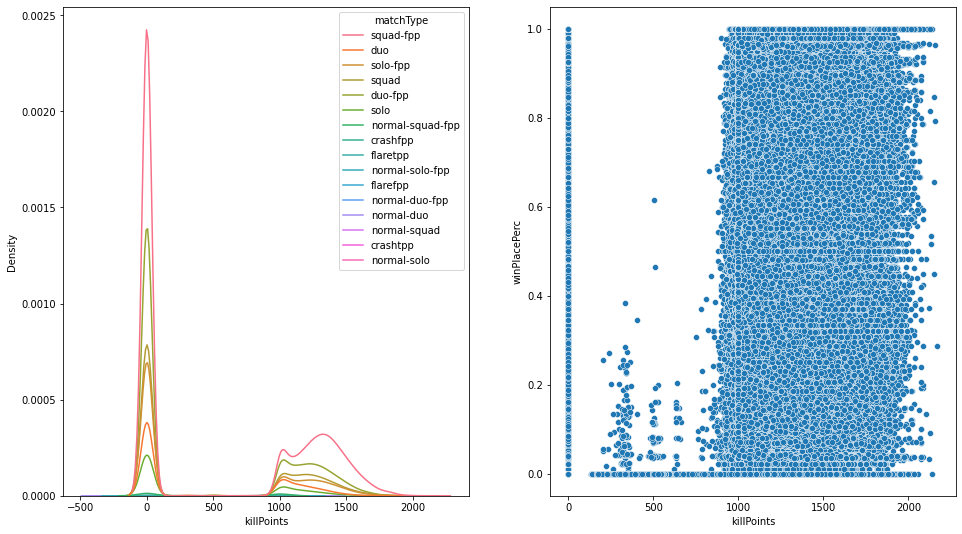

In [73]:
EDA_2graph('killPoints')

최종 순위와 상관없이 고른 분포를 보이고 있어 큰 관련성은 없어보인다.

<span style='color:red'> **최종 순위와 큰 관련이 없다** </span>

#### 중요도 분류

|분류|<span style='color:green'> **최종순위와 매우 높은 연관성** </span>|<span style='color:blue'> **최종순위와 연관성이 있음** </span>|<span style='color:purple'> **최종순위와 연관 있으나 feature 결정 시 낮은 우선순위** </span>|<span style='color:red'> **최종순위와 큰 관련이 없음** </span>|
|--|--|--|--|--|
|Kill|headshotKills, killPlace, longestKill|damageDealt, DBNOs, kills, killStreaks|roadKills||
|Heal|heals, boosts||||
|Assist||assists|revives||
|Farming|||weaponsAcquired||
|Activity|walkDistance, swimDistance, rideDistance||||
|특이변수|vehicleDestroys|||teamKills|
|그 외||||winPoints, killPoints, rankPoints, numGroups, maxPlace, matchDuration|

- <span style='color:orange'> **feature 분류 기준으로 사용 예정** </span>

matchType

# 4. 데이터 전처리

In [40]:
#핵심 feature에 적용할 dataframe 생성
train_main = train.copy()
train_main

Id         groupId         matchId  assists  boosts  \
0        7f96b2f878858a  4d4b580de459be  a10357fd1a4a91        0       0   
1        eef90569b9d03c  684d5656442f9e  aeb375fc57110c        0       0   
2        1eaf90ac73de72  6a4a42c3245a74  110163d8bb94ae        1       0   
3        4616d365dd2853  a930a9c79cd721  f1f1f4ef412d7e        0       0   
4        315c96c26c9aac  de04010b3458dd  6dc8ff871e21e6        0       0   
...                 ...             ...             ...      ...     ...   
4446961  afff7f652dbc10  d238e426f50de7  18492834ce5635        0       0   
4446962  f4197cf374e6c0  408cdb5c46b2ac  ee854b837376d9        0       1   
4446963  e1948b1295c88a  e26ac84bdf7cef  6d0cd12784f1ab        0       0   
4446964  cc032cdd73b7ac  c2223f35411394  c9c701d0ad758a        0       4   
4446965  0d8e7ed728b6fd  8c74f72fedf5ff  62a16aabcc095c        0       2   

         damageDealt  DBNOs  headshotKills  heals  killPlace  killPoints  \
0               0.00      0              0      0         60        1241   
1              91.47      0              0      0         57           0   
2              68.00      0              0      0         47           0   
3              32.90      0              0      0         75           0   
4             100.00      0              0      0         45           0   
...              ...    ...            ...    ...        ...         ...   
4446961         0.00      0              0      0         74        1029   
4446962        44.15      0              0      0         69           0   
4446963        59.06      0              0      0         66           0   
4446964       180.40      1              1      2         11           0   
4446965       268.00      0              0      1         18           0   

         kills  killStreaks  longestKill  matchDuration  matchType  maxPlace  \
0            0            0         0.00           1306  squad-fpp        28   
1            0            0         0.00           1777  squad-fpp        26   
2            0            0         0.00           1318        duo        50   
3            0            0         0.00           1436  squad-fpp        31   
4            1            1        58.53           1424   solo-fpp        97   
...        ...          ...          ...            ...        ...       ...   
4446961      0            0         0.00           1873  squad-fpp        29   
4446962      0            0         0.00           1435       solo        93   
4446963      0            0         0.00           1321  squad-fpp        28   
4446964      2            1        98.50           1373  squad-fpp        26   
4446965      2            1        78.25           1766   solo-fpp        98   

         numGroups  rankPoints  revives  rideDistance  roadKills  \
0               26          -1        0        0.0000          0   
1               25        1484        0        0.0045          0   
2               47        1491        0        0.0000          0   
3               30        1408        0        0.0000          0   
4               95        1560        0        0.0000          0   
...            ...         ...      ...           ...        ...   
4446961         28          -1        0     1292.0000          0   
4446962         93        1501        0        0.0000          0   
4446963         28        1500        0        0.0000          0   
4446964         25        1418        2        0.0000          0   
4446965         94        1590        0     1369.0000          0   

         swimDistance  teamKills  vehicleDestroys  walkDistance  \
0               0.000          0                0        244.80   
1              11.040          0                0       1434.00   
2               0.000          0                0        161.80   
3               0.000          0                0        202.70   
4               0.000          0                0         49.75   
...            

In [44]:
def auto_describe(df_name,feature):
  print(df_name[feature].describe(),'\n\n','~'*90,'\n')
  print(df_name[feature].value_counts(),'\n\n','~'*90,'\n')

  data1= train[[feature,'winPlacePerc']]
  print(data1.corr(),'\n\n','~'*90)

  data2= df_name[[feature,'winPlacePerc']]
  print(data2.corr())

    
def auto_graph(df_name,feature):  
  plt.figure(figsize=(16,9))
  plt.subplot(1,2,1)
  sns.scatterplot(data = train, x = feature, y = 'winPlacePerc')
  
  plt.subplot(1,2,2)
  sns.scatterplot(data = df_name, x = feature, y = 'winPlacePerc')
  plt.show()

## 핵심 feature
### : walkDistance, killPlace, boosts, heals, kills, killStreaks, longestKill, rideDistance

### 1) walkDistance

1m이하로 움직인 유저기록 삭제 

(핵 or 스쿼드 인원맞추기용이던 어쨋든 1m이상 안움직였다면 실질적으로 게임에 참여하지 않았다고 판단)


데이터 개수: 4446965 -> 4340947      <span style='color:red'> **data 106063개 감소** </span>

상관도: 0.810888  ->  0.808946      <span style='color:red'> **상관도 0.001942 감소** </span>

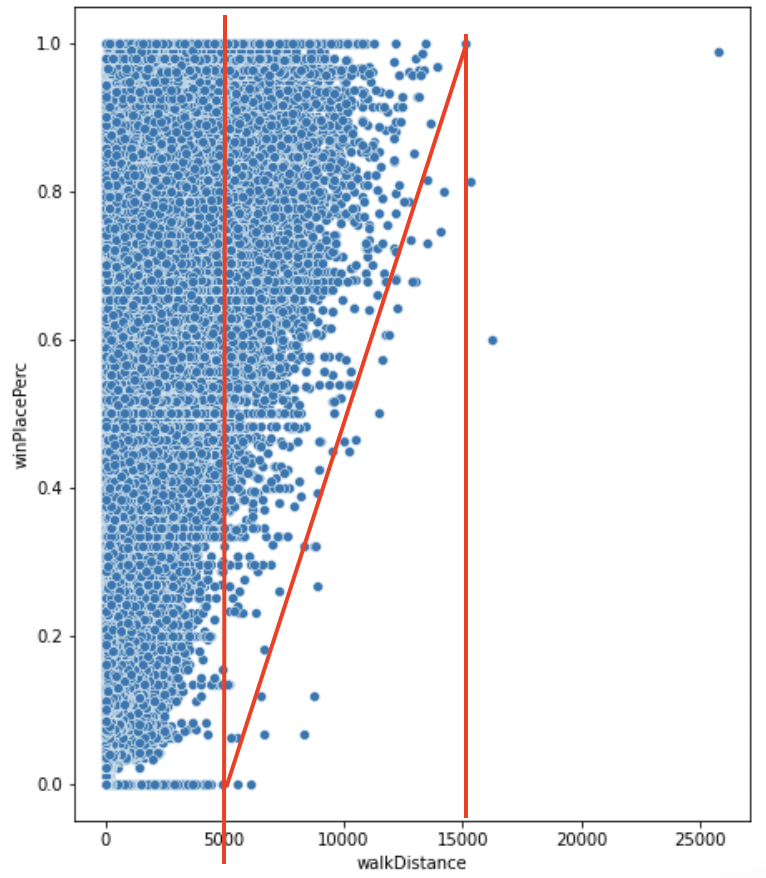

count    4.340902e+06
mean     1.182310e+03
std      1.183415e+03
min      1.001000e+00
25%      1.735000e+02
50%      7.360000e+02
75%      2.010000e+03
max      1.396000e+04
Name: walkDistance, dtype: float64 

 ~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~ 

1007.000    955
1098.000    945
1047.000    939
1036.000    934
1018.000    934
           ... 
8718.000      1
7674.000      1
9099.000      1
1.051         1
9023.000      1
Name: walkDistance, Length: 34445, dtype: int64 

 ~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~ 

              walkDistance  winPlacePerc
walkDistance      1.000000      0.810888
winPlacePerc      0.810888      1.000000 

 ~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~
              walkDistance  winPlacePerc
walkDistance      1.000000      0.808946
winPlacePerc      0.808946      1.000000


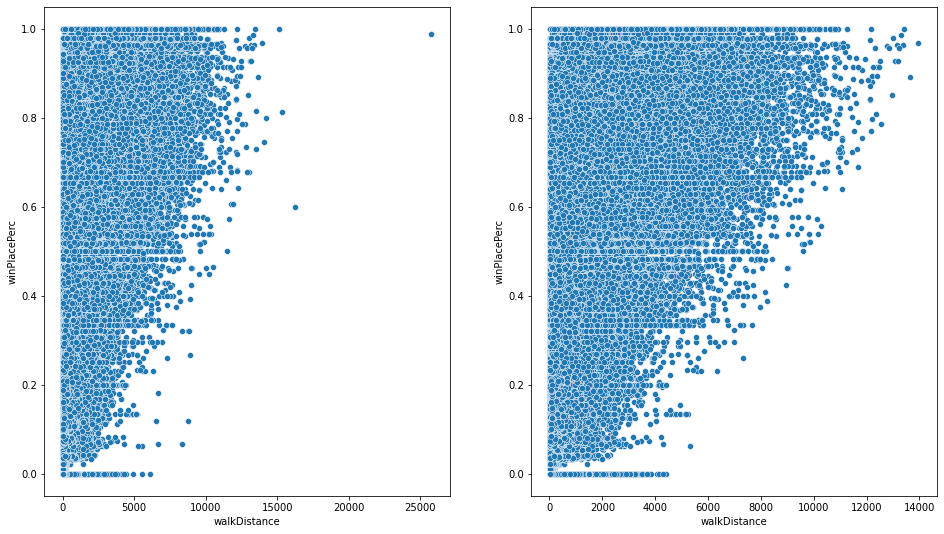

In [45]:
train_main = train_main[(((train_main['winPlacePerc']+0.48) / (train_main['walkDistance'])) > 1/10000) & (train_main['walkDistance']>1) ]

auto_describe(train_main,'walkDistance')
auto_graph(train_main,'walkDistance')

### 2) killPlace

아웃라이어 제거

데이터 개수: 4340947 -> 4339564      <span style='color:red'> **data 1383개 감소 / 누적 107446개 감소** </span>


상관도:  -0.719069 -> -0.710594    <span style='color:red'> **상관도 0.008475 감소** </span>

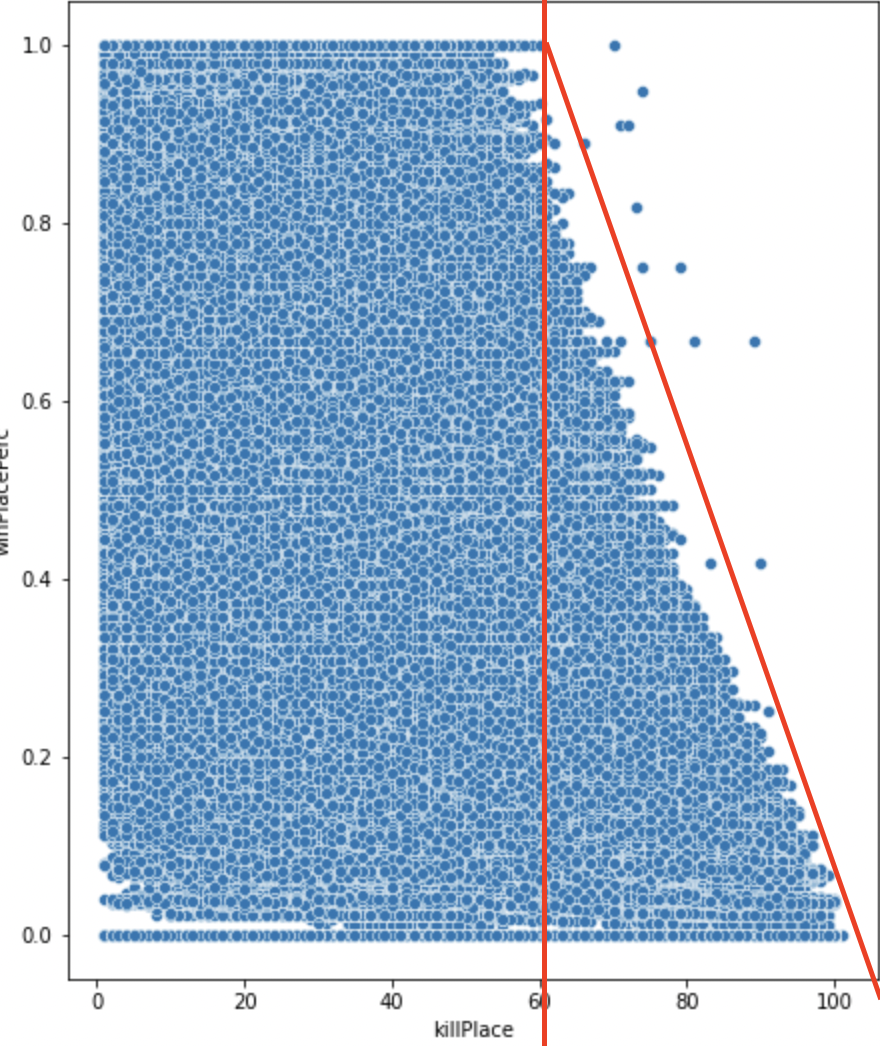

count    4.339564e+06
mean     4.674857e+01
std      2.702273e+01
min      1.000000e+00
25%      2.300000e+01
50%      4.600000e+01
75%      7.000000e+01
max      1.010000e+02
Name: killPlace, dtype: float64 

 ~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~ 

1      47589
3      47568
2      47565
4      47551
5      47537
       ...  
97     12684
98      7914
99      3534
100       17
101        1
Name: killPlace, Length: 101, dtype: int64 

 ~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~ 

              killPlace  winPlacePerc
killPlace      1.000000     -0.719069
winPlacePerc  -0.719069      1.000000 

 ~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~
              killPlace  winPlacePerc
killPlace      1.000000     -0.710594
winPlacePerc  -0.710594      1.000000


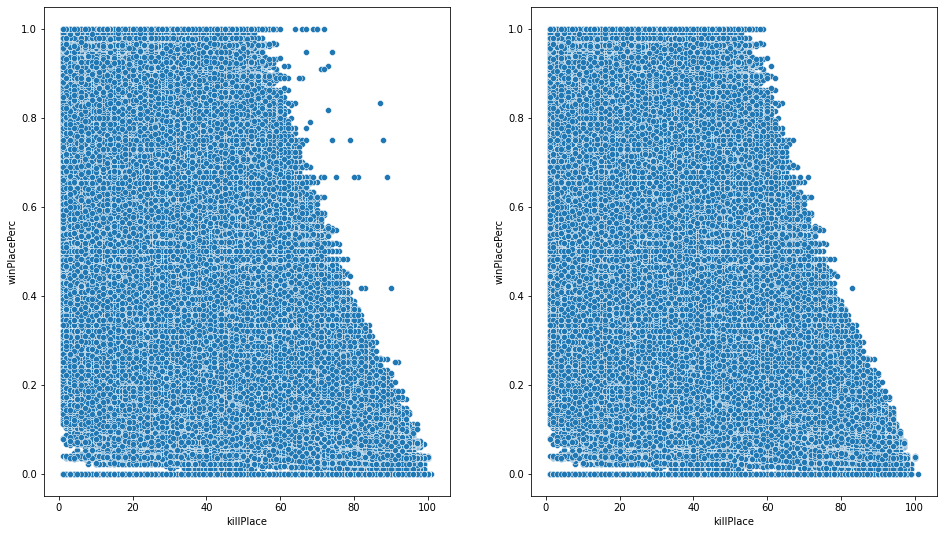

In [46]:
train_main = train_main[(((train_main['winPlacePerc']) / (train_main['killPlace']-100)) > -1/40)]

auto_describe(train_main,'killPlace')
auto_graph(train_main,'killPlace')


### 3) boosts

아웃라이어 제거

데이터 개수: 4339564 ->  4339538     <span style='color:red'> **data 26개 감소 / 누적 107472개 감소** </span>


상관도: 0.634234  ->  0.632513   <span style='color:red'> **상관도 0.00172 감소** </span>

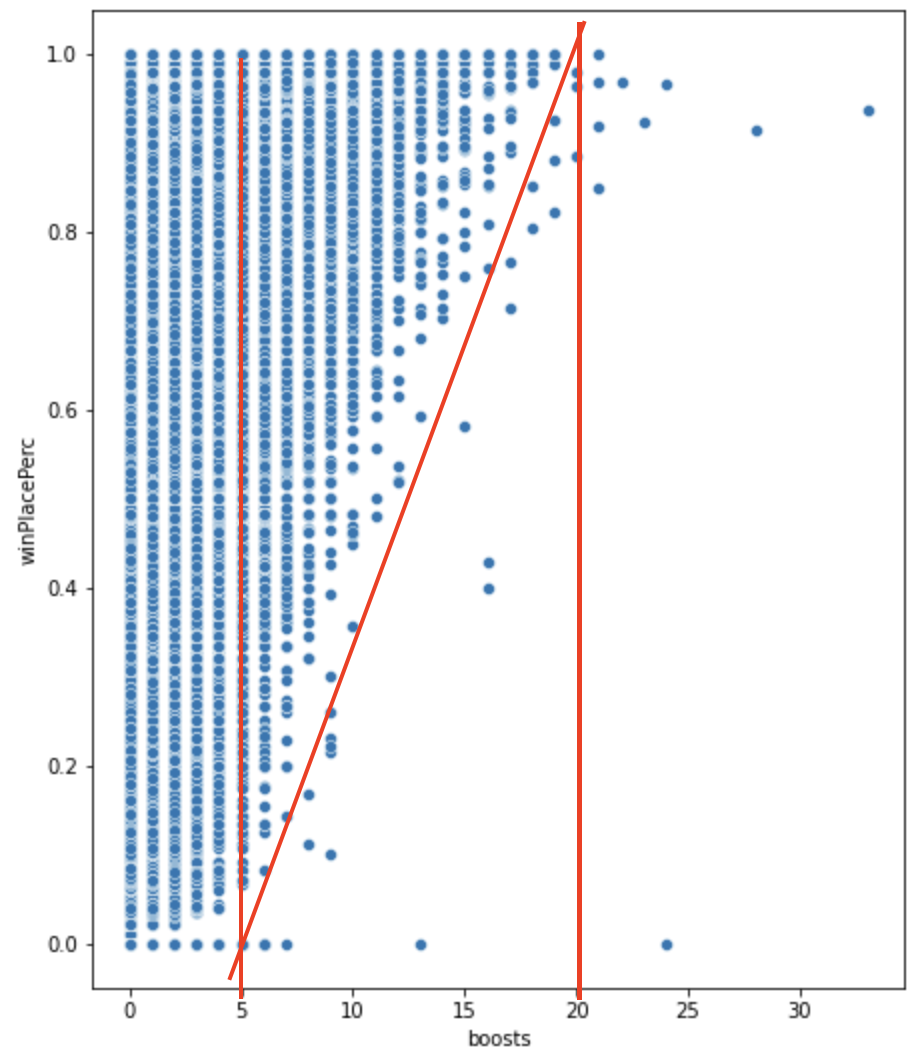

count    4.339538e+06
mean     1.133978e+00
std      1.727350e+00
min      0.000000e+00
25%      0.000000e+00
50%      0.000000e+00
75%      2.000000e+00
max      2.000000e+01
Name: boosts, dtype: float64 

 ~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~ 

0     2414414
1      679976
2      491224
3      295827
4      195703
5      120257
6       70095
7       37621
8       18889
9        8632
10       3989
11       1642
12        726
13        294
14        125
15         61
16         28
17         15
18         13
19          5
20          2
Name: boosts, dtype: int64 

 ~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~ 

                boosts  winPlacePerc
boosts        1.000000      0.634234
winPlacePerc  0.634234      1.000000 

 ~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~
                boosts  winPlacePerc
boosts        1.000000      0.632513
win

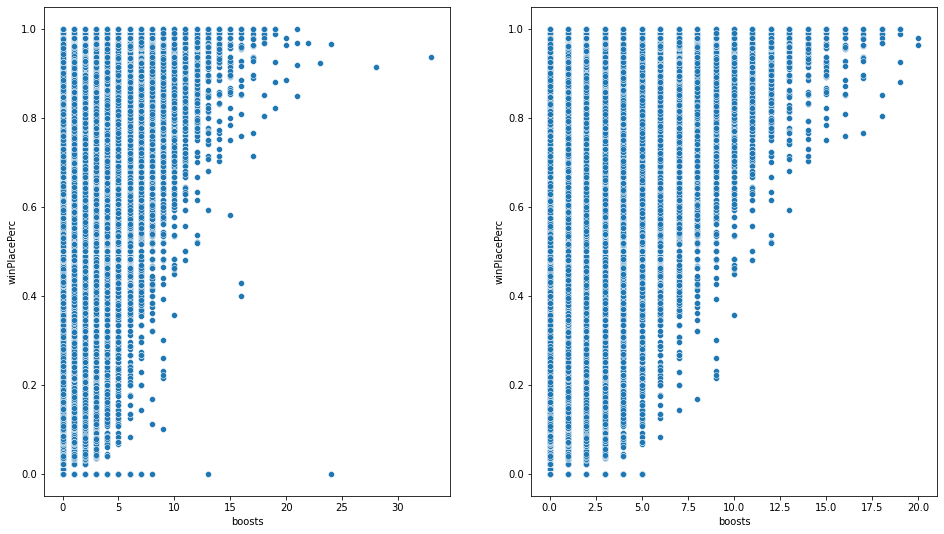

In [47]:
train_main = train_main[((train_main['winPlacePerc']+ 0.4 ) / (train_main['boosts'])) > 1/15 ]

auto_describe(train_main,'boosts')
auto_graph(train_main,'boosts')


### heals

아웃라이어 제거

데이터 개수: 4339538 ->       <span style='color:red'> **data 26개 감소 / 누적 107472개 감소** </span>


상관도: 0.634234  ->  0.632513   <span style='color:red'> **상관도 0.00172 감소** </span>

In [ ]:
train_main = train_main[(((train_main['winPlacePerc']+0.48) / (train_main['walkDistance'])) > 1/10000)]

auto_describe(train_main,'boosts')
auto_graph(train_main,'boosts')

In [ ]:
kills

In [ ]:
train_main = train_main[(((train_main['winPlacePerc']+0.48) / (train_main['walkDistance'])) > 1/10000)]

auto_describe(train_main,'boosts')
auto_graph(train_main,'boosts')

In [ ]:
killStreaks

In [ ]:
train_main = train_main[(((train_main['winPlacePerc']+0.48) / (train_main['walkDistance'])) > 1/10000)]

auto_describe(train_main,'boosts')
auto_graph(train_main,'boosts')

In [ ]:
logestKill

In [ ]:
train_main = train_main[(((train_main['winPlacePerc']+0.48) / (train_main['walkDistance'])) > 1/10000)]

auto_describe(train_main,'boosts')
auto_graph(train_main,'boosts')

In [ ]:
rideDistance

In [ ]:
train_main = train_main[(((train_main['winPlacePerc']+0.48) / (train_main['walkDistance'])) > 1/10000)]

auto_describe(train_main,'boosts')
auto_graph(train_main,'boosts')

## 서브 feature
### : weaponsAcquired, damageDealt, headshotKills, assists, DBNOs

In [95]:
train_sub = train_main.copy()
train_sub

assists  boosts  damageDealt  DBNOs  headshotKills  heals  killPlace  \
0              0       0         0.00      0              0      0         60   
1              0       0        91.47      0              0      0         57   
2              1       0        68.00      0              0      0         47   
3              0       0        32.90      0              0      0         75   
4              0       0       100.00      0              0      0         45   
...          ...     ...          ...    ...            ...    ...        ...   
4446961        0       0         0.00      0              0      0         74   
4446962        0       1        44.15      0              0      0         69   
4446963        0       0        59.06      0              0      0         66   
4446964        0       4       180.40      1              1      2         11   
4446965        0       2       268.00      0              0      1         18   

         killPoints  kills  killStreaks  longestKill  matchDuration  \
0              1241      0            0         0.00           1306   
1                 0      0            0         0.00           1777   
2                 0      0            0         0.00           1318   
3                 0      0            0         0.00           1436   
4                 0      1            1        58.53           1424   
...             ...    ...          ...          ...            ...   
4446961        1029      0            0         0.00           1873   
4446962           0      0            0         0.00           1435   
4446963           0      0            0         0.00           1321   
4446964           0      2            1        98.50           1373   
4446965           0      2            1        78.25           1766   

         matchType  maxPlace  numGroups  rankPoints  revives  rideDistance  \
0        squad-fpp        28         26          -1        0        0.0000   
1        squad-fpp        26         25        1484        0        0.0045   
2              duo        50         47        1491        0        0.0000   
3        squad-fpp        31         30        1408        0        0.0000   
4         solo-fpp        97         95        1560        0        0.0000   
...            ...       ...        ...         ...      ...           ...   
4446961  squad-fpp        29         28          -1        0     1292.0000   
4446962       solo        93         93        1501        0        0.0000   
4446963  squad-fpp        28         28        1500        0        0.0000   
4446964  squad-fpp        26         25        1418        2        0.0000   
4446965   solo-fpp        98         94        1590        0     1369.0000   

         roadKills  swimDistance  teamKills  vehicleDestroys  walkDistance  \
0                0         0.000          0                0        244.80   
1                0        11.040          0                0       1434.00   
2                0         0.000          0                0        161.80   
3                0         0.000          0                0        202.70   
4                0         0.000          0                0         49.75   
...            ...           ...        ...              ...           ...   
4446961          0         0.000          0                0       1019.00   
4446962          0         0.000          0                0         81.70   
4446963          0         2.184          0                0        788.70   
4446964          0         0.000          0                0       2748.00   
4446965          0         0.000          0                0       1244.00   

         weaponsAcquired  winPoints  winPlacePerc  
0                      1       1466        0.4444  
1                      5          0        0.6400  
2                      2          0        0.7755  
3                      3          0        0.1667  
4                      2          0        0.1875

### weaponsAcquired

아웃라이어 제거 

(너무 많이 제거하면 다른 feature에 너무 큰 영향을 주기 때문에 적당히 줄임)

데이터 개수:  ->     <span style='color:red'> **data 개 감소 / 누적 개 감소** </span>


상관도: 0.583806  ->  0.577172   <span style='color:red'> **상관도 0.006634 감소** </span>

In [93]:
train_sub = train_sub[((train_sub['winPlacePerc']+ 11 ) / (train_sub['weaponsAcquired'])) > 1/5 ]

auto_describe(train_main,'boosts')
auto_graph(train_main,'boosts')

count    4.339446e+06
mean     3.733672e+00
std      2.378231e+00
min      0.000000e+00
25%      2.000000e+00
50%      3.000000e+00
75%      5.000000e+00
max      5.900000e+01
Name: weaponsAcquired, dtype: float64 

 ~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~ 

3     767264
2     766504
4     688687
1     567258
5     540075
6     368956
7     226409
0     141049
8     128336
9      68246
10     35380
11     17892
12      9230
13      4612
14      2683
15      1347
16       977
18       554
17       550
20       423
19       357
21       288
22       283
24       265
26       194
23       184
25       167
28       160
27       118
29       113
30       106
32        96
31        69
34        67
33        66
35        54
36        51
38        39
40        37
41        35
37        32
42        29
39        24
47        20
45        18
43        17
44        16
46        16
52        14
48        13
50        12
49        11
54        10
5

### damageDealt

아웃라이어 제거 

데이터 개수:4339446  ->     <span style='color:red'> **data 92개 감소 / 누적 107564개 감소** </span>


상관도: 0.  ->  0.   <span style='color:red'> **상관도 0. 감소** </span>

In [ ]:
train_sub = train_sub[(((train_sub['winPlacePerc']+0.48) / (train_sub['walkDistance'])) > 1/10000)]

auto_describe(train_main,'boosts')
auto_graph(train_main,'boosts')

In [ ]:
### headshotKills

아웃라이어 제거 

데이터 개수:4339446  ->     <span style='color:red'> **data 92개 감소 / 누적 107564개 감소** </span>


상관도: 0.  ->  0.   <span style='color:red'> **상관도 0. 감소** </span>

In [ ]:
train_sub = train_sub[(((train_sub['winPlacePerc']+0.48) / (train_sub['walkDistance'])) > 1/10000)]

auto_describe(train_main,'boosts')
auto_graph(train_main,'boosts')

In [ ]:
### assists

아웃라이어 제거 

데이터 개수:4339446  ->     <span style='color:red'> **data 92개 감소 / 누적 107564개 감소** </span>


상관도: 0.  ->  0.   <span style='color:red'> **상관도 0. 감소** </span>

In [ ]:
train_sub = train_sub[(((train_sub['winPlacePerc']+0.48) / (train_sub['walkDistance'])) > 1/10000)]

auto_describe(train_main,'boosts')
auto_graph(train_main,'boosts')

In [ ]:
### DBNOs

아웃라이어 제거 

데이터 개수:4339446  ->     <span style='color:red'> **data 92개 감소 / 누적 107564개 감소** </span>


상관도: 0.  ->  0.   <span style='color:red'> **상관도 0. 감소** </span>

In [ ]:
train_sub = train_sub[(((train_sub['winPlacePerc']+0.48) / (train_sub['walkDistance'])) > 1/10000)]

auto_describe(train_main,'boosts')
auto_graph(train_main,'boosts')

# 5. 모델링 & 평가

In [ ]:
X = train.drop('winPlacePerc',axis=1)
y = train['winPlacePerc']

In [ ]:
model = LGBMRegressor()
model.fit(X,y)
pred = model.predict(test)

# 6. 결과